## 1. Download/Load SP500 stocks prices data

In [2]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [3]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

In [4]:
sp500['Symbol'] = sp500['Symbol'].str.replace(".", "-")

symbols_list = sp500['Symbol'].unique().tolist()

In [5]:
end_date = '2023-11-30'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

In [6]:
df = yf.download(tickers=symbols_list, start=start_date, end=end_date)

[*********************100%***********************]  503 of 503 completed


In [7]:
df = df.stack()
df.index.names = ['date', 'ticker']
df.index = df.index.set_levels([pd.to_datetime(df.index.levels[0]), df.index.levels[1]])
df.columns = df.columns.str.lower()

In [8]:
df.head()

adj close      close       high        low       open  \
date       ticker                                                          
2015-12-02 A       37.841980  40.419998  41.459999  40.369999  41.070000   
           AAL     41.876389  43.820000  44.529999  43.529999  44.090000   
           AAPL    26.465130  29.070000  29.527500  29.020000  29.334999   
           ABBV    40.855938  57.720001  59.389999  57.369999  59.169998   
           ABT     38.927662  45.220001  45.720001  45.119999  45.430000   

                        volume  
date       ticker               
2015-12-02 A         4713200.0  
           AAL       8010400.0  
           AAPL    133546400.0  
           ABBV      7663000.0  
           ABT       4840400.0

## 2. Calculate features and technical indicators for each stock

In [ ]:
# Techincal Indicators
# Garman-Klass Volatility, RSI, Bollinger Bands, ATR, MACD, Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [9]:
# Garman-Klass Volatility
df['garman-klass-vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2 - \
                    (2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

In [10]:
# RSI
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

#df.xs('AAPL', level=1)['rsi'].plot()

In [11]:
# Bollinger Bands
# pandas_ta.bbands(close=df.xs('AAPL', level=1)['adj close'], length=20)

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

In [12]:
# ATR
# pandas_ta.atr(high=df['high'], low=df['low'], close=df['adj close'], length=14)

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'], low=stock_data['low'], 
                        close=stock_data['adj close'], length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

In [13]:
# MACD
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

In [14]:
# Dollar Value (Turnover)
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [15]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                         'high', 'low', 'close']]

# Average dollar volume for each month
# df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')

In [16]:
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
    df.unstack()[last_cols].resample('M').last().stack('ticker')],
          axis = 1)).dropna()

In [17]:
# Calculate 5-year rolling average of dollar volume for each stocks before filtering

data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

In [18]:
# Choose top 150 stocks by volume and drop unnecessary columns
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [19]:
# g = df.xs('AAPL', level=1)

def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close'].pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                      upper=x.quantile(1-outlier_cutoff))).add(1).pow(1/lag).sub(1))
        
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

In [20]:
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-12-31 AAL      50.711880  0.975348  3.972856  3.884601  3.928729   
           AAPL     40.006573 -0.679255  3.754309  3.703448  3.728878   
           ABBV     73.694969  1.681838  4.338743  4.289143  4.313943   
           ABT      51.533798  0.310911  3.978439  3.904342  3.941390   
           ACN     140.201797  0.777549  4.967736  4.907500  4.937618   
...                       ...       ...       ...       ...       ...   
2023-11-30 VRTX    351.000000  1.200570  5.968426  5.825455  5.896940   
           VZ       37.759998 -2.101556  3.660433  3.580988  3.620710   
           WFC      43.779999 -1.470877  3.814444  3.703654  3.759049   
           WMT     155.502457 -1.991180  5.149333  5.023587  5.086460   
           XOM     102.339996 -1.414792  4.682348  4.626921  4.654634   

                   garman-klass-vol      macd        rsi  return_1m  \
date       ticker                                                     
2017-12-31 AAL            -0.000305  1.250035  59.214284   0.030501   
           AAPL           -0.001526 -0.224382  47.784592  -0.015246   
           ABBV           -0.031544  0.195027  55.000964  -0.002167   
           ABT            -0.004710  0.252693  59.877716   0.012418   
           ACN            -0.003561  0.291735  65.003668   0.034322   
...                             ...       ...        ...        ...   
2023-11-30 VRTX            0.000157 -1.306949  45.282933  -0.030681   
           VZ              0.000031  2.121619  71.727064   0.074865   
           WFC             0.000066  0.955361  63.883648   0.110644   
           WMT             0.000035 -1.465727  42.370164  -0.044856   
           XOM             0.000272 -1.056021  41.103883  -0.024319   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-12-31 AAL      0.055325   0.031653   0.006292   0.023994    0.009787  
           AAPL     0.002359   0.032902   0.028535   0.019684    0.033479  
           ABBV     0.035171   0.031007   0.051953   0.047851    0.039985  
           ABT      0.025851   0.024323   0.028884   0.030147    0.035524  
           ACN      0.037002   0.045983   0.037860   0.029824    0.024265  
...                      ...        ...        ...        ...         ...  
2023-11-30 VRTX     0.004676   0.002539   0.013654   0.021325    0.008686  
           VZ       0.081897   0.033066   0.016285   0.003099    0.003262  
           WFC      0.039719   0.022732   0.018795  -0.004612   -0.005001  
           WMT     -0.012110  -0.013569   0.010786   0.011741    0.003249  
           XOM     -0.062799  -0.024312   0.003143  -0.005038   -0.004217  

[10347 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [21]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

In [22]:
factor_data = factor_data.resample('M').last().div(100)

In [23]:
factor_data.index.name = 'date'
factor_data =factor_data.join(data['return_1m']).sort_index()

In [ ]:
# Check for correct join
# factor_data.xs("AAPL", level=1)
# factor_data.xs("MSFT", level=1)

In [24]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations>=10]

In [25]:
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

In [26]:
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-12-31 AAL     0.0106 -0.0107  0.0006  0.0074  0.0169   0.030501
           AAPL    0.0106 -0.0107  0.0006  0.0074  0.0169  -0.015246
           ABBV    0.0106 -0.0107  0.0006  0.0074  0.0169  -0.002167
           ABT     0.0106 -0.0107  0.0006  0.0074  0.0169   0.012418
           ACN     0.0106 -0.0107  0.0006  0.0074  0.0169   0.034322
...                   ...     ...     ...     ...     ...        ...
2023-10-31 VRTX   -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.041324
           VZ     -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.107061
           WFC    -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.026676
           WMT    -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.021760
           XOM    -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.099762

[10155 rows x 6 columns]

In [27]:
# Calculate Rolling Factor betas
betas = factor_data.groupby(level=1, group_keys=False).apply(lambda x: RollingOLS(endog=x['return_1m'],
                                                                         exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                                                         window=min(24, x.shape[0]),
                                                                         min_nobs=len(x.columns)+1)
                                                    .fit(params_only=True)
                                                    .params.drop('const', axis=1))

In [28]:
data = data.join(betas.groupby('ticker').shift())

In [29]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data.loc[:, factors] = data.groupby(level=1, group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

In [30]:
data = data.dropna()
data = data.drop('adj close', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10122 entries, (Timestamp('2017-12-31 00:00:00', freq='M'), 'AAL') to (Timestamp('2023-11-30 00:00:00', freq='M'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10122 non-null  float64
 1   bb_high           10122 non-null  float64
 2   bb_low            10122 non-null  float64
 3   bb_mid            10122 non-null  float64
 4   garman-klass-vol  10122 non-null  float64
 5   macd              10122 non-null  float64
 6   rsi               10122 non-null  float64
 7   return_1m         10122 non-null  float64
 8   return_2m         10122 non-null  float64
 9   return_3m         10122 non-null  float64
 10  return_6m         10122 non-null  float64
 11  return_9m         10122 non-null  float64
 12  return_12m        10122 non-null  float64
 13  Mkt-RF            10122 non-null  float64
 14  SMB               10122 non-null  floa

## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [31]:
from sklearn.cluster import KMeans

In [32]:
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                          init='random',
                          random_state=0).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

In [33]:
data

atr   bb_high    bb_low    bb_mid  garman-klass-vol  \
date       ticker                                                             
2017-12-31 AAL     0.975348  3.972856  3.884601  3.928729         -0.000305   
           AAPL   -0.679255  3.754309  3.703448  3.728878         -0.001526   
           ABBV    1.681838  4.338743  4.289143  4.313943         -0.031544   
           ABT     0.310911  3.978439  3.904342  3.941390         -0.004710   
           ACN     0.777549  4.967736  4.907500  4.937618         -0.003561   
...                     ...       ...       ...       ...               ...   
2023-11-30 VRTX    1.200570  5.968426  5.825455  5.896940          0.000157   
           VZ     -2.101556  3.660433  3.580988  3.620710          0.000031   
           WFC    -1.470877  3.814444  3.703654  3.759049          0.000066   
           WMT    -1.991180  5.149333  5.023587  5.086460          0.000035   
           XOM    -1.414792  4.682348  4.626921  4.654634          0.000272   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2017-12-31 AAL     1.250035  59.214284   0.030501   0.055325   0.031653   
           AAPL   -0.224382  47.784592  -0.015246   0.002359   0.032902   
           ABBV    0.195027  55.000964  -0.002167   0.035171   0.031007   
           ABT     0.252693  59.877716   0.012418   0.025851   0.024323   
           ACN     0.291735  65.003668   0.034322   0.037002   0.045983   
...                     ...        ...        ...        ...        ...   
2023-11-30 VRTX   -1.306949  45.282933  -0.030681   0.004676   0.002539   
           VZ      2.121619  71.727064   0.074865   0.081897   0.033066   
           WFC     0.955361  63.883648   0.110644   0.039719   0.022732   
           WMT    -1.465727  42.370164  -0.044856  -0.012110  -0.013569   
           XOM    -1.056021  41.103883  -0.024319  -0.062799  -0.024312   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-12-31 AAL      0.006292   0.023994    0.009787  1.251394  1.351929   
           AAPL     0.028535   0.019684    0.033479  1.298721 -0.301041   
           ABBV     0.051953   0.047851    0.039985  0.480771  0.427427   
           ABT      0.028884   0.030147    0.035524  0.822451 -0.179051   
           ACN      0.037860   0.029824    0.024265  1.209893 -0.166000   
...                      ...        ...         ...       ...       ...   
2023-11-30 VRTX     0.013654   0.021325    0.008686  0.535810  0.066669   
           VZ       0.016285   0.003099    0.003262  0.497055 -0.355527   
           WFC      0.018795  -0.004612   -0.005001  1.083116 -0.107034   
           WMT      0.010786   0.011741    0.003249  0.614308 -0.453122   
           XOM      0.003143  -0.005038   -0.004217  1.147252  0.300969   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-12-31 AAL     0.571306  0.376773  0.634713        3  
           AAPL   -0.613842  0.610139  0.538996        1  
           ABBV   -0.065086  0.300746  0.215051        2  
           ABT    -0.522296  0.273866  0.982858        3  
           ACN    -0.314893  0.278261  0.176483        3  
...                     ...       ...       ...      ...  
2023-11-30 VRTX   -0.947761  0.042286  0.858352        3  
           VZ      0.061572  0.296875  0.522677        0  
           WFC     1.399434 -0.735982 -0.553681        1  
           WMT    -0.310268  0.332418  0.716914        3  
           XOM     0.627967 -0.480462  0.696123        3  

[10122 rows x 19 columns]

In [34]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


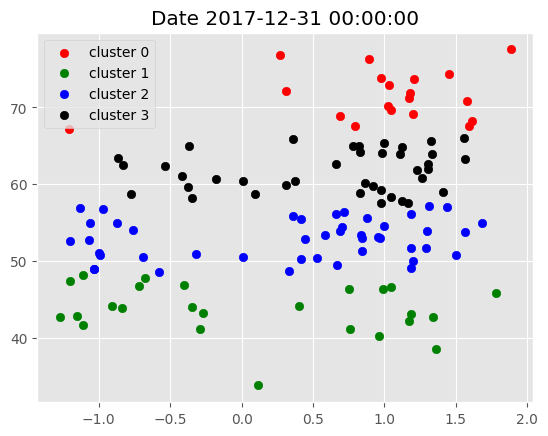

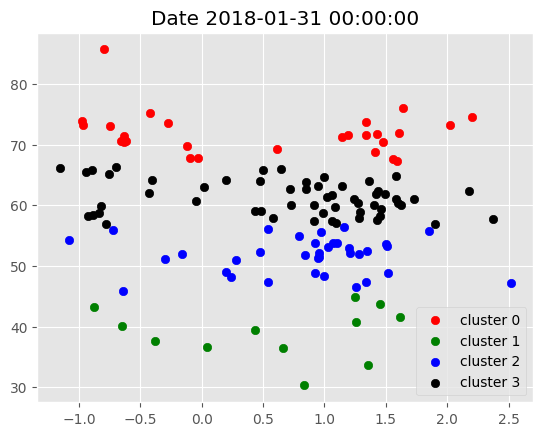

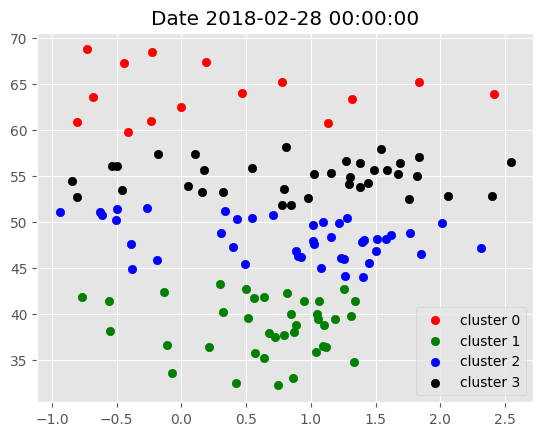

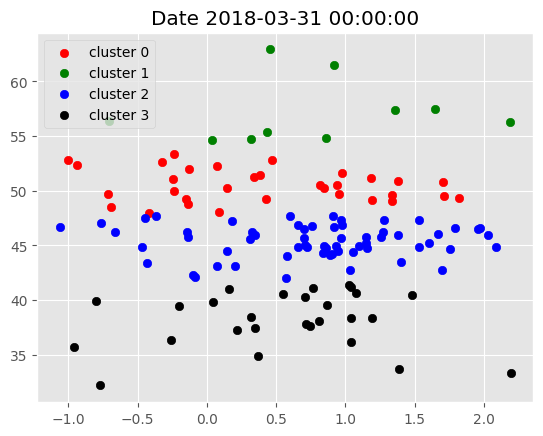

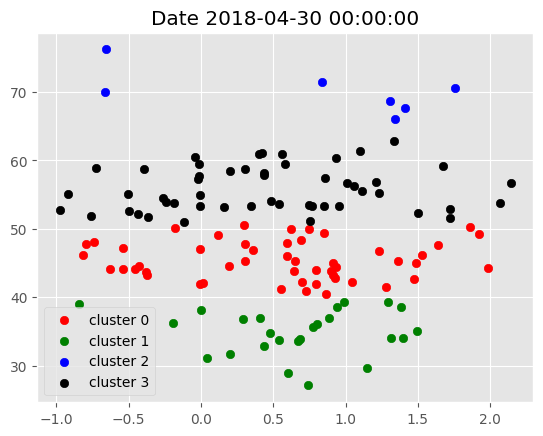

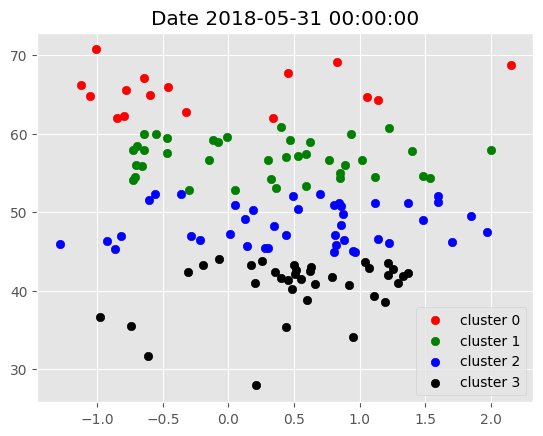

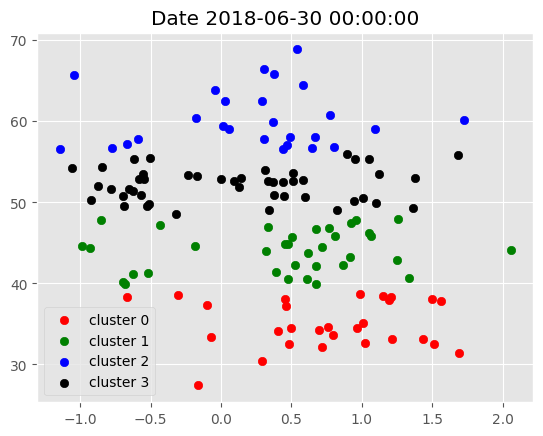

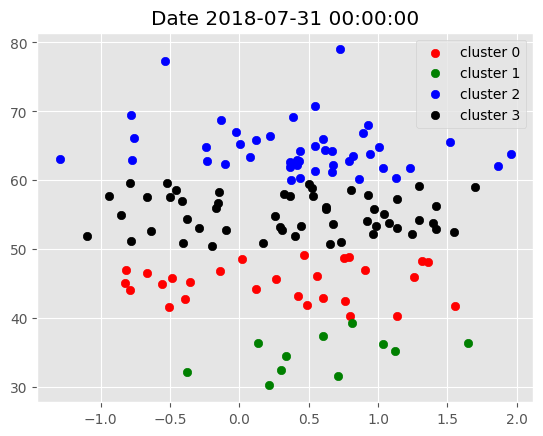

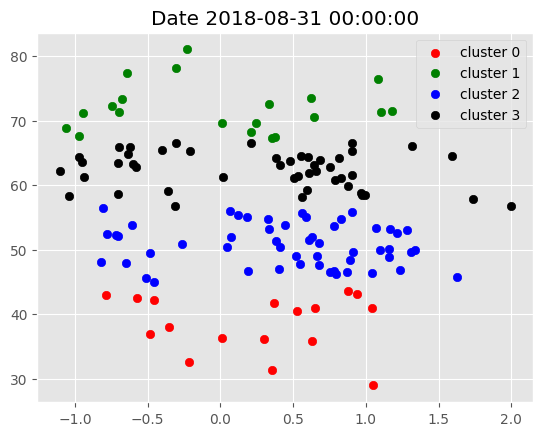

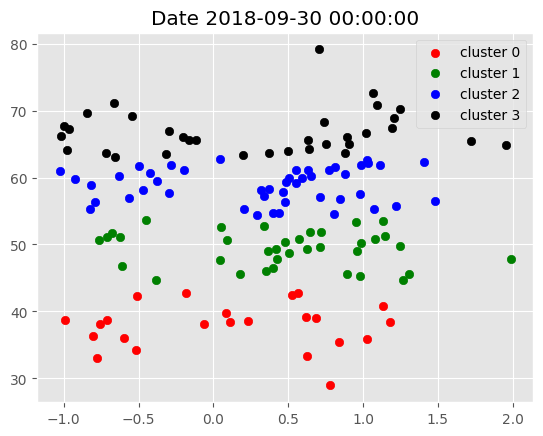

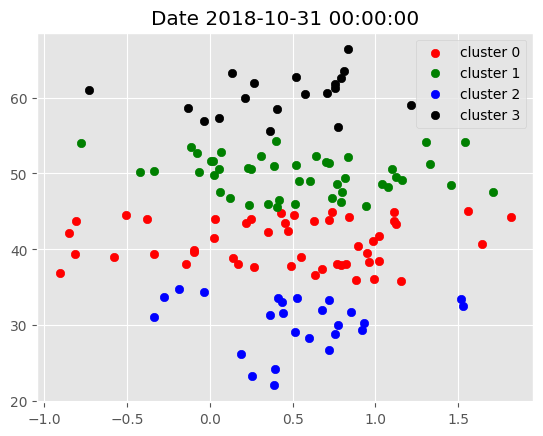

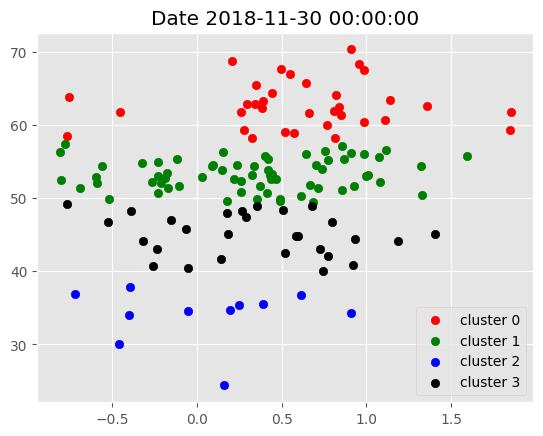

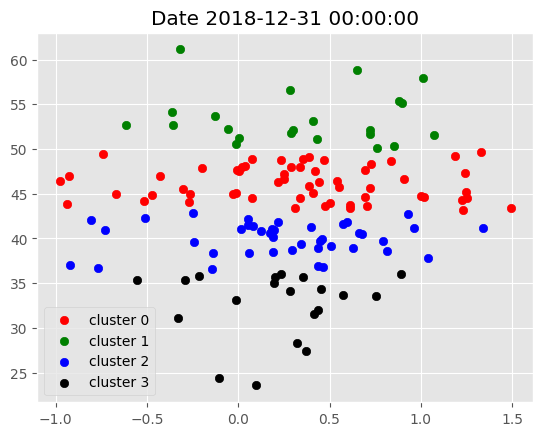

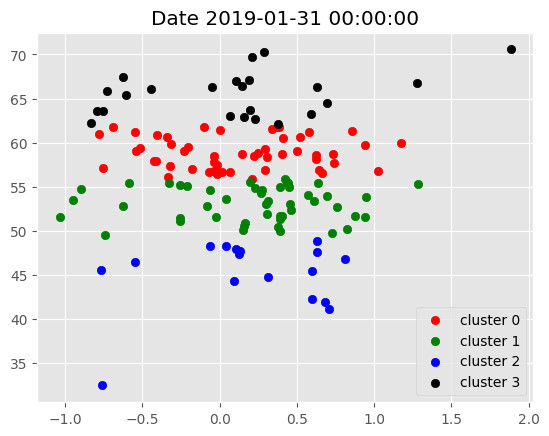

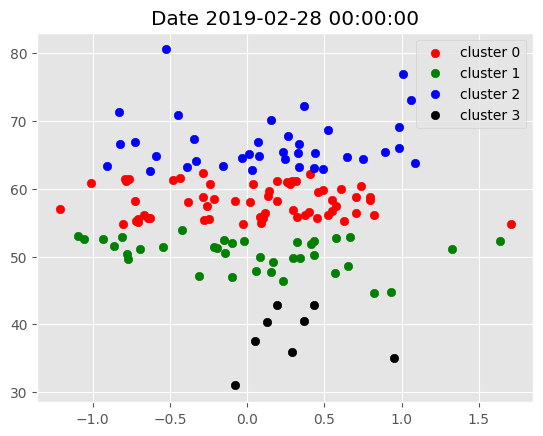

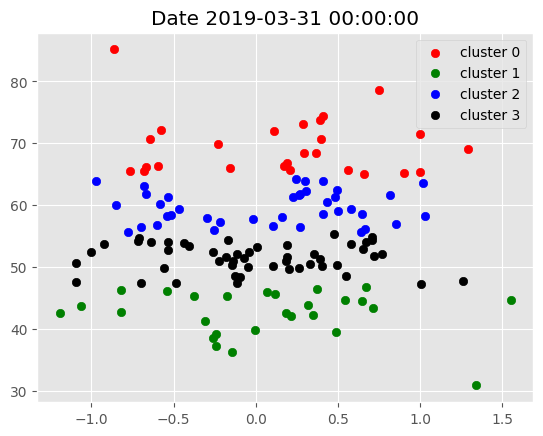

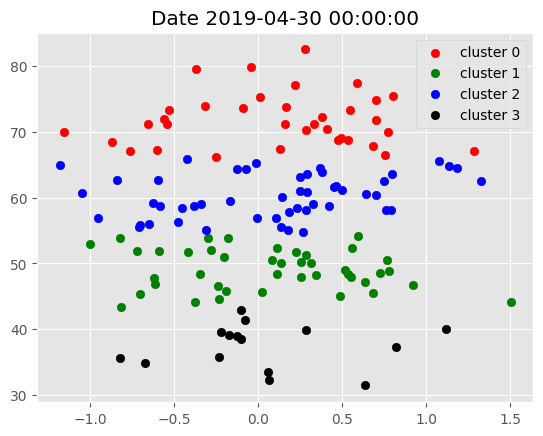

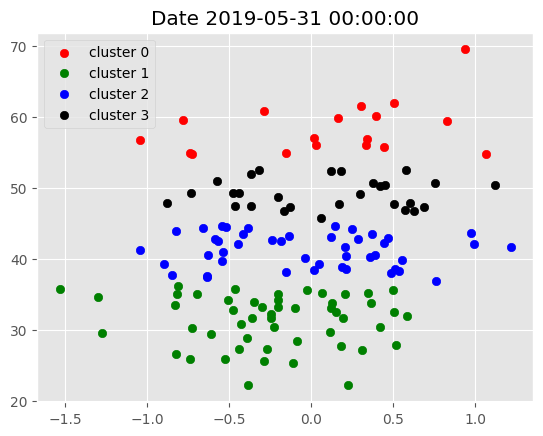

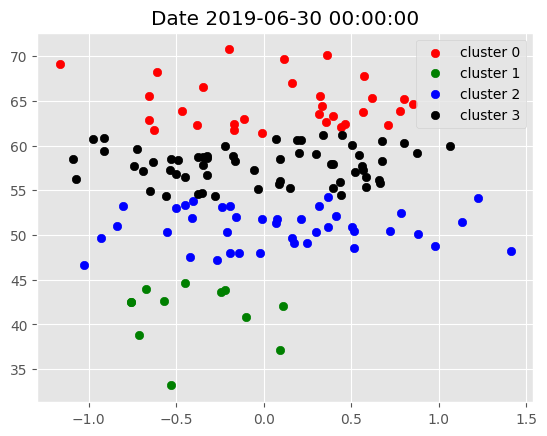

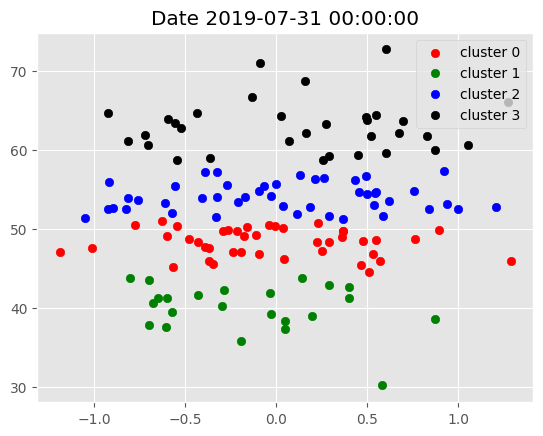

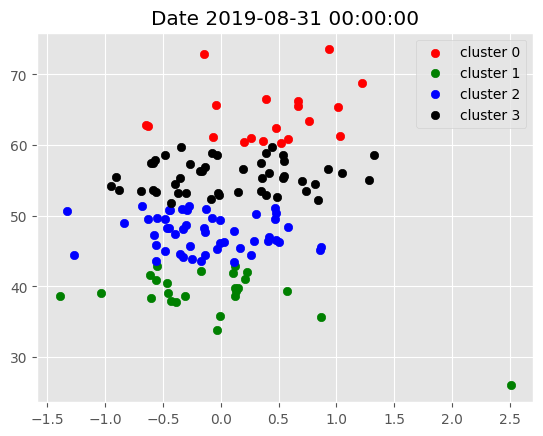

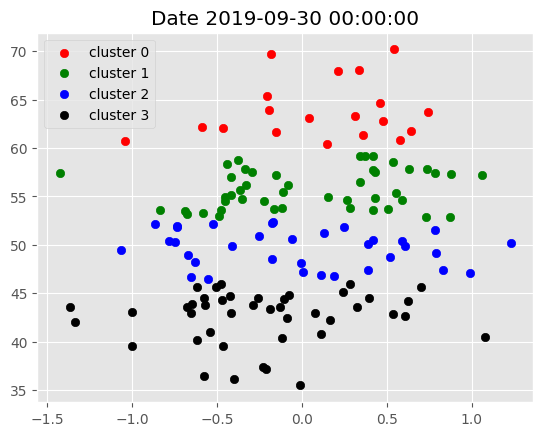

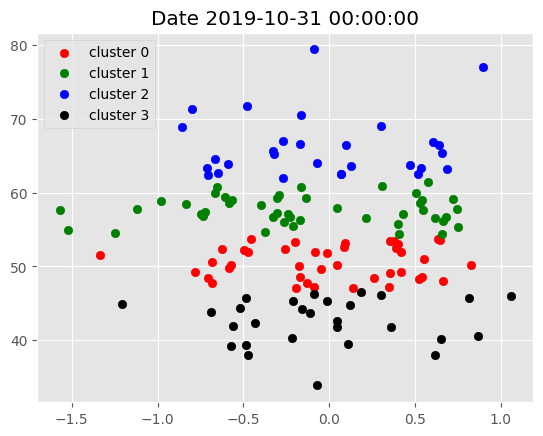

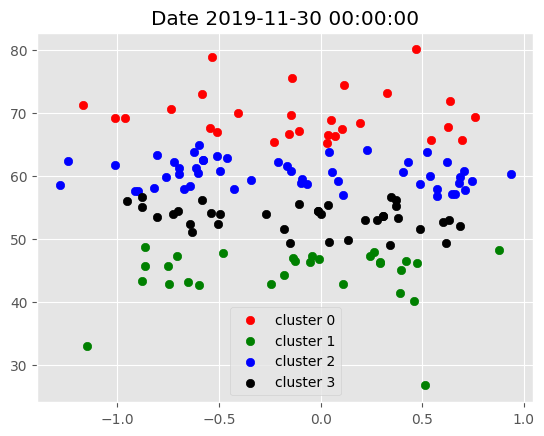

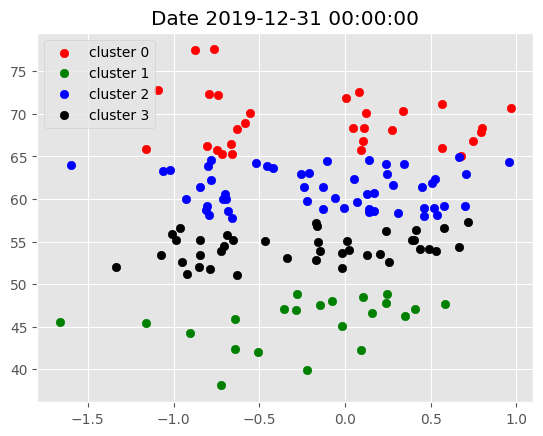

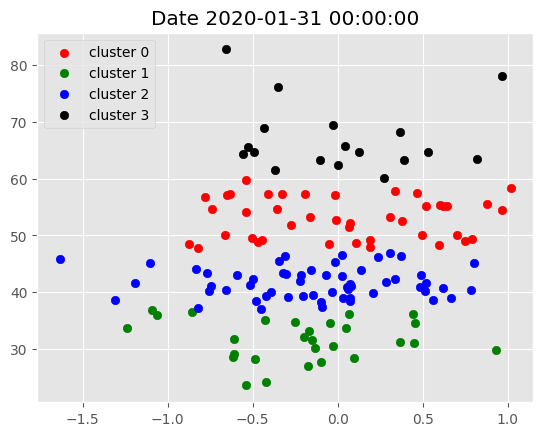

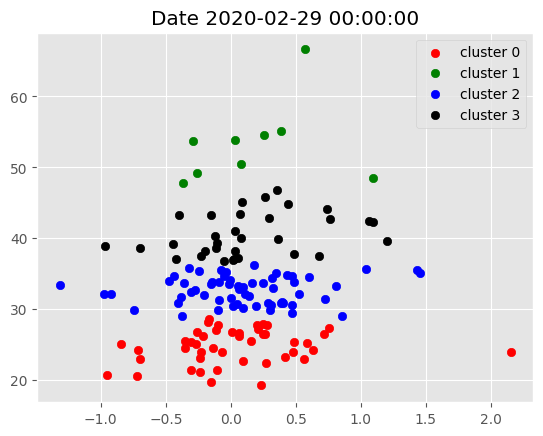

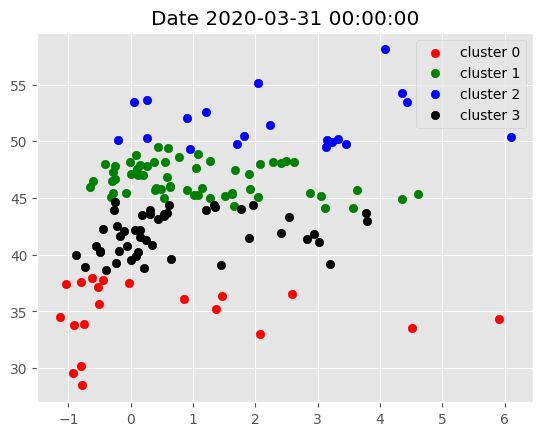

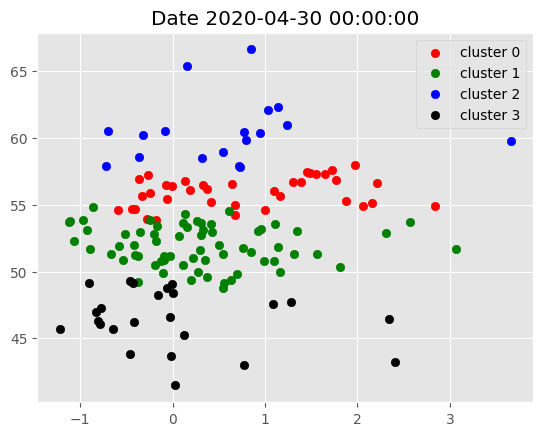

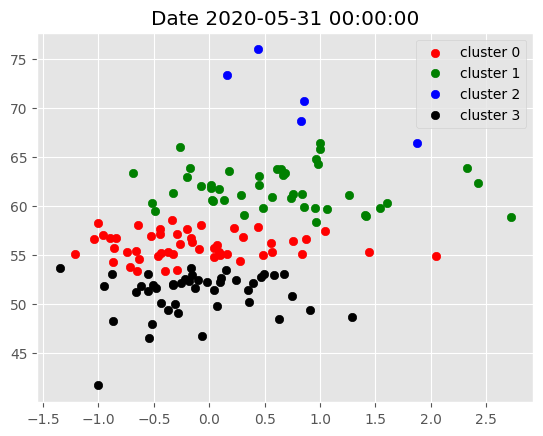

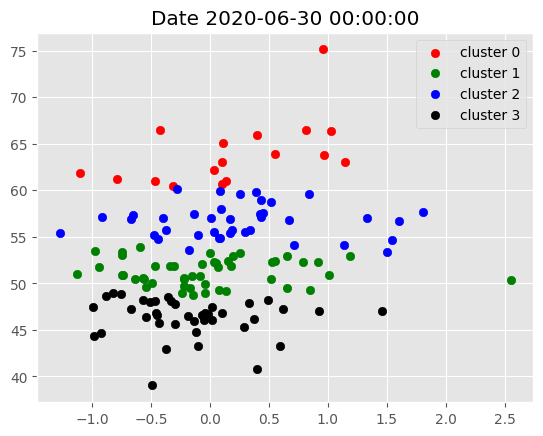

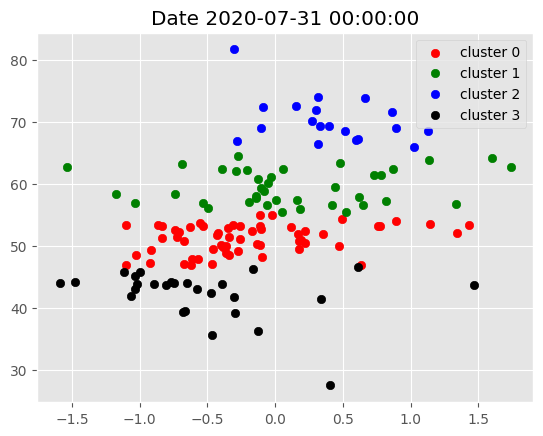

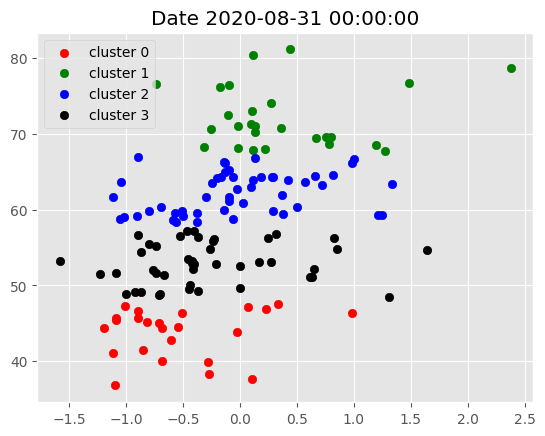

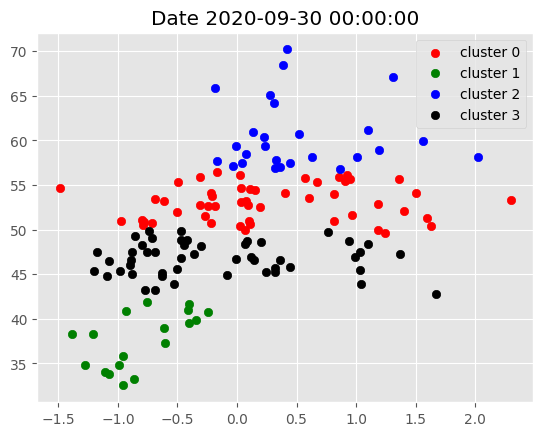

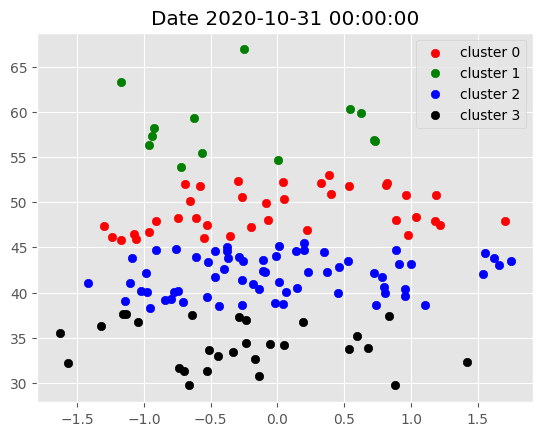

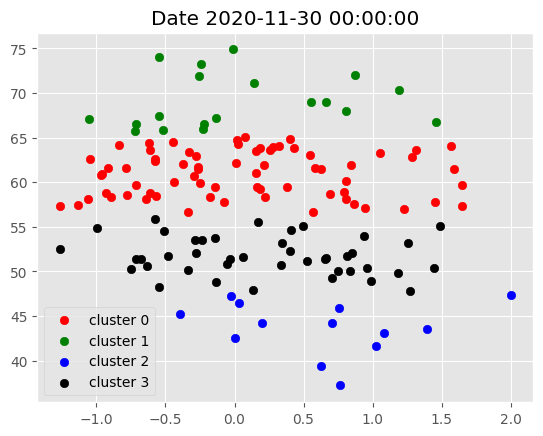

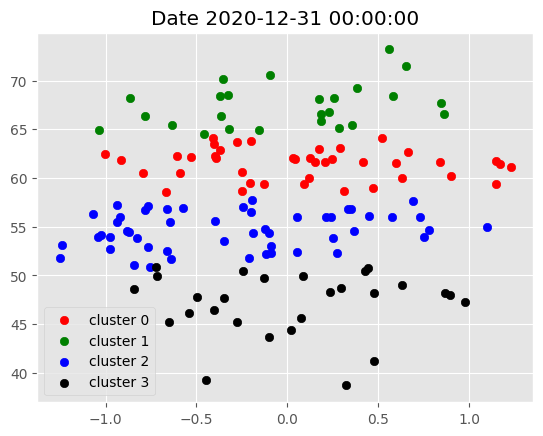

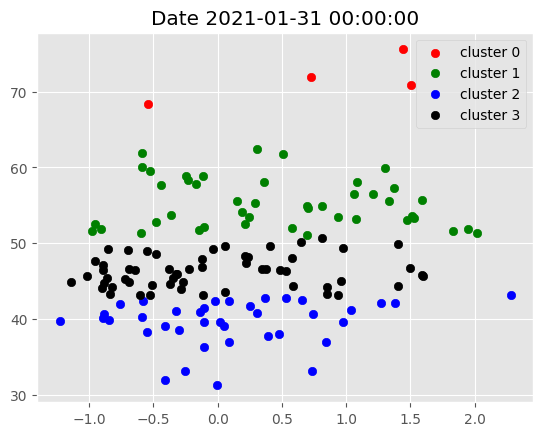

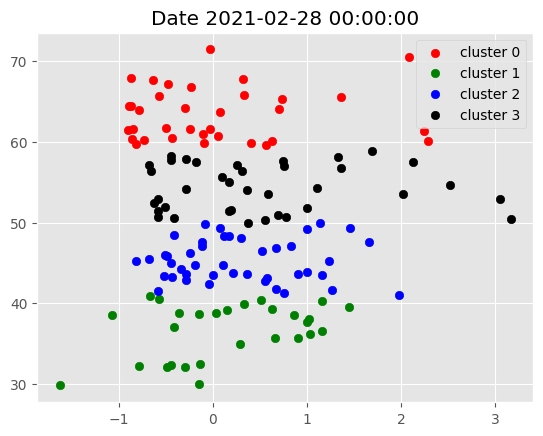

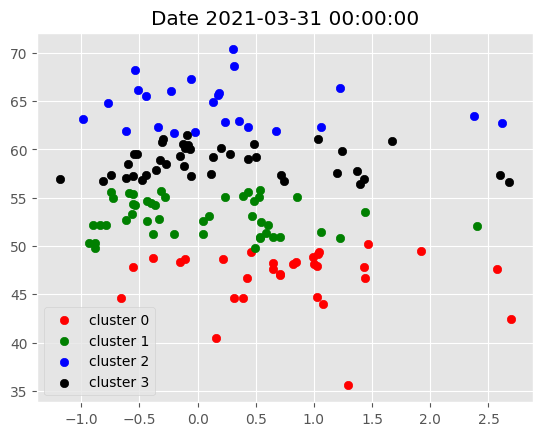

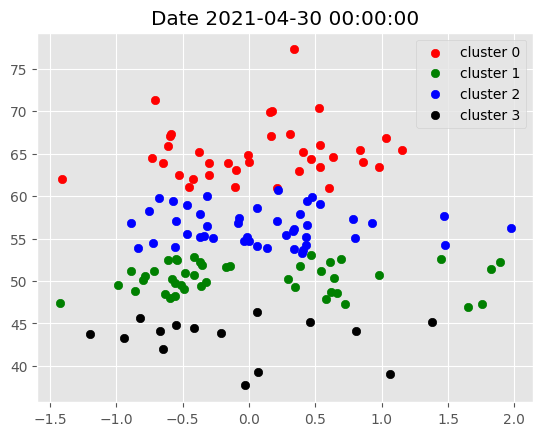

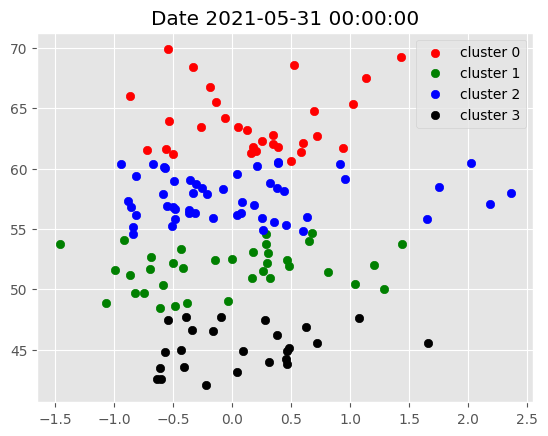

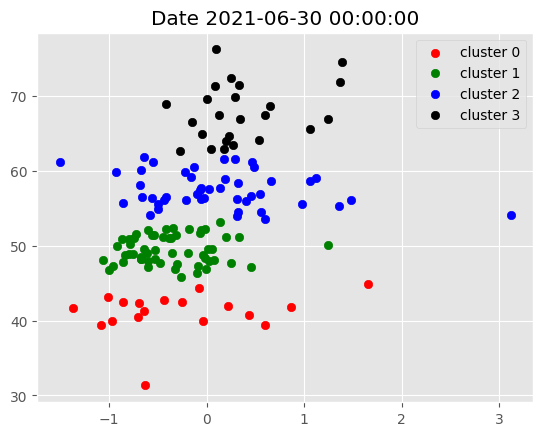

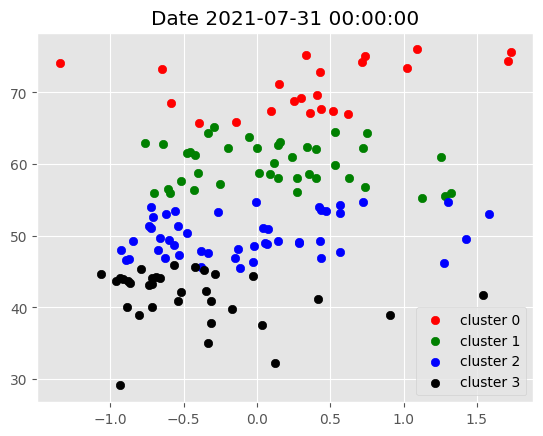

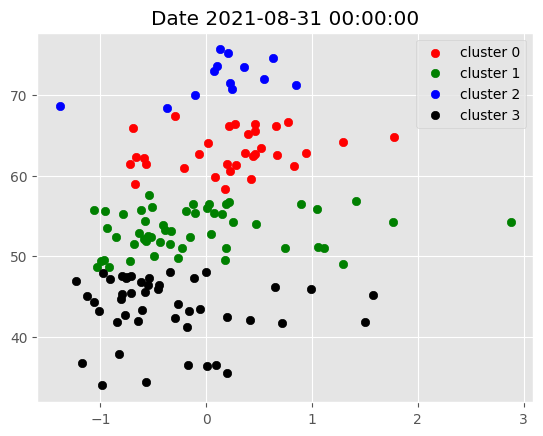

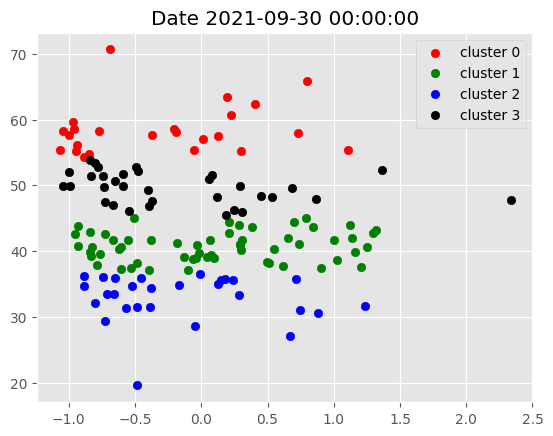

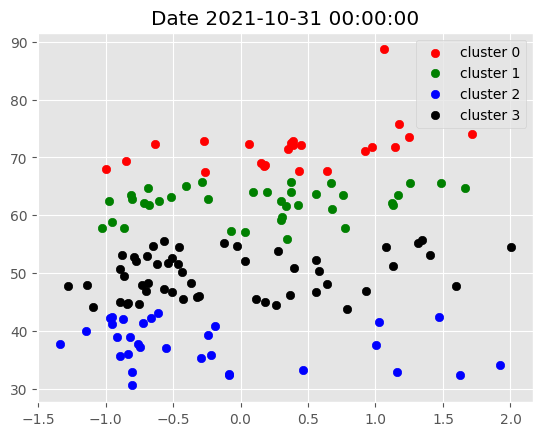

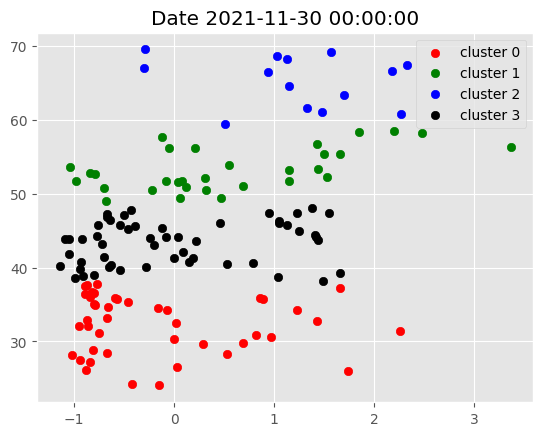

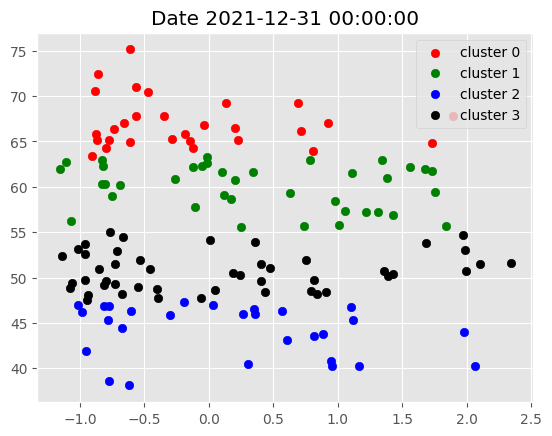

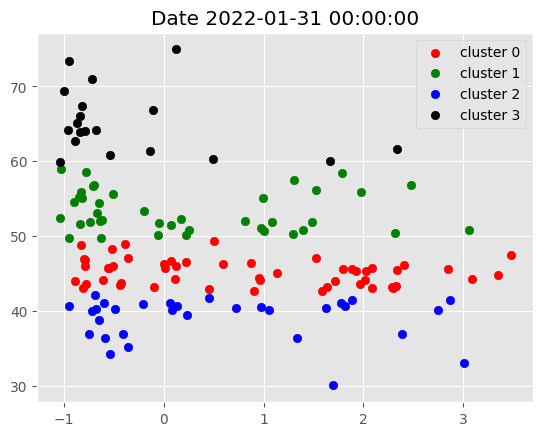

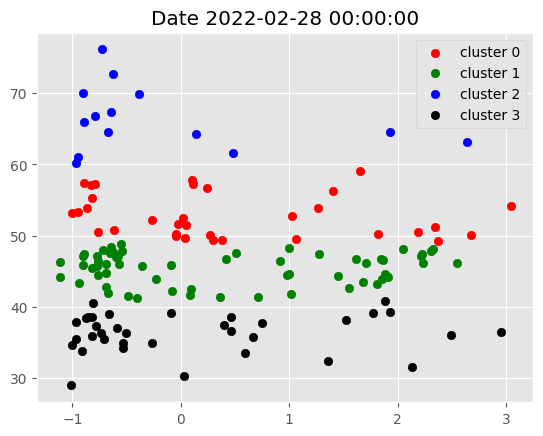

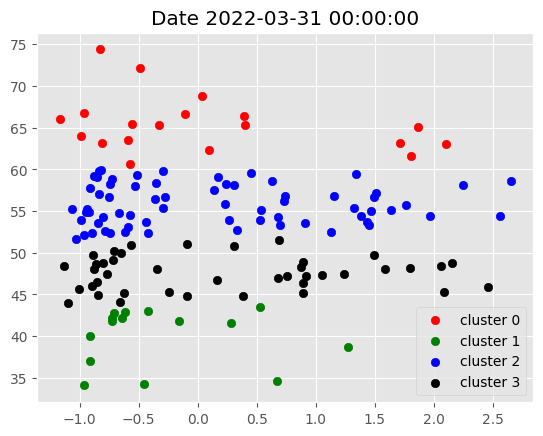

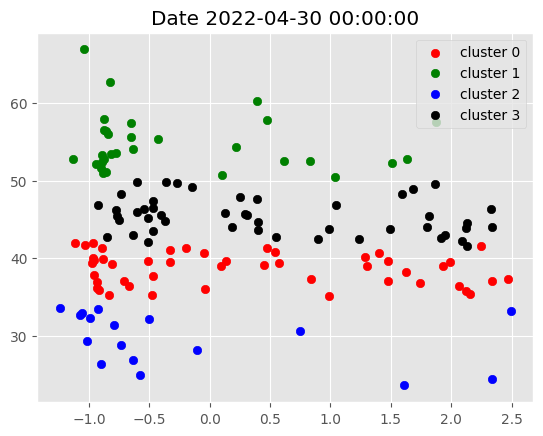

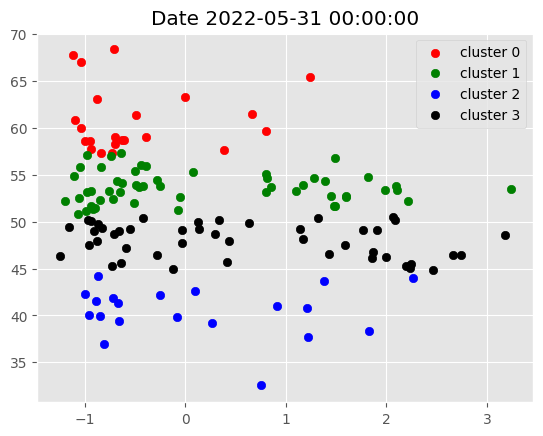

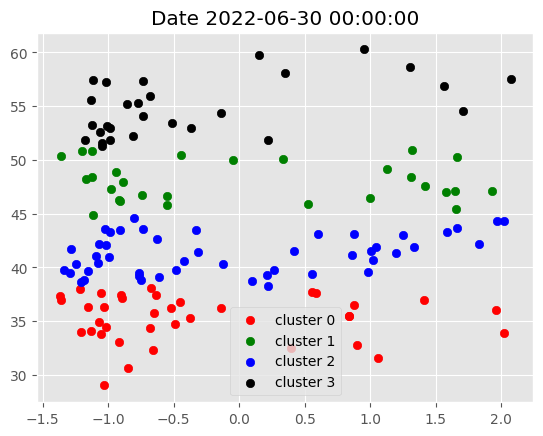

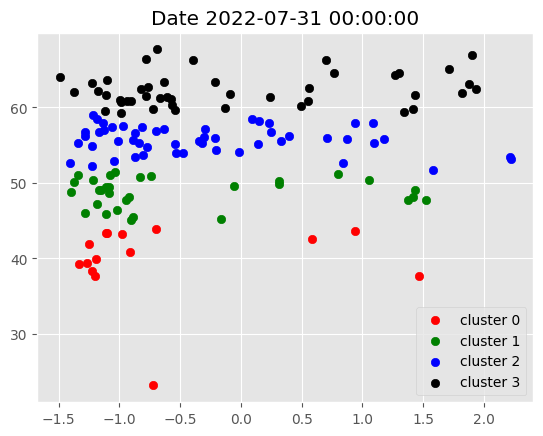

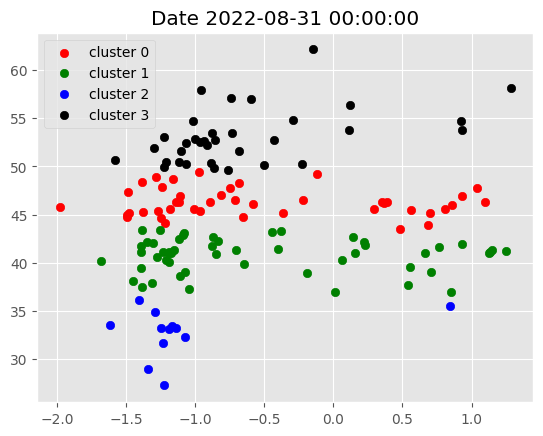

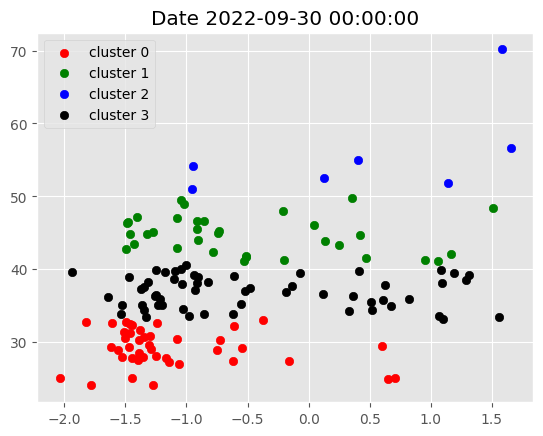

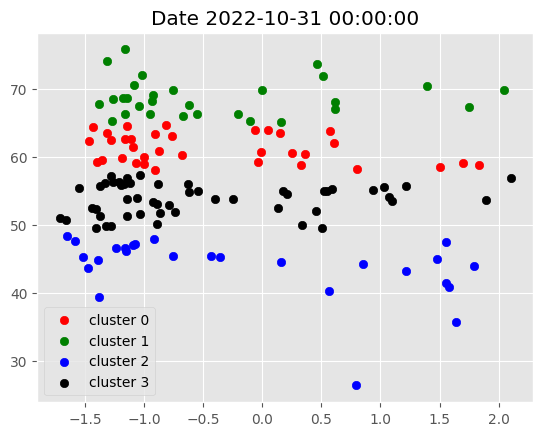

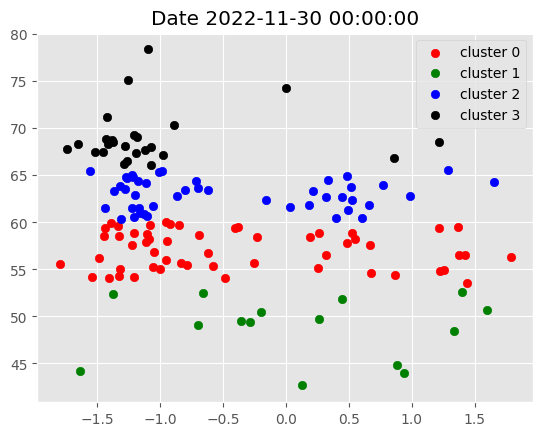

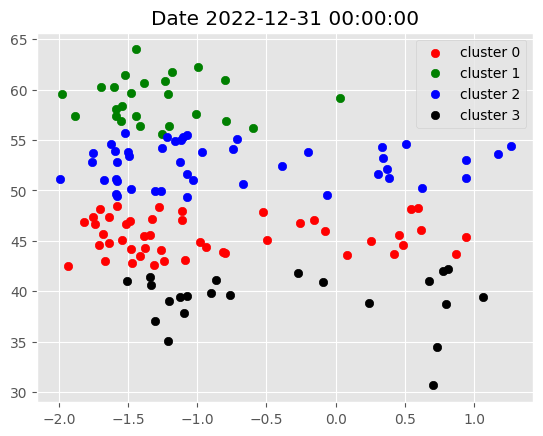

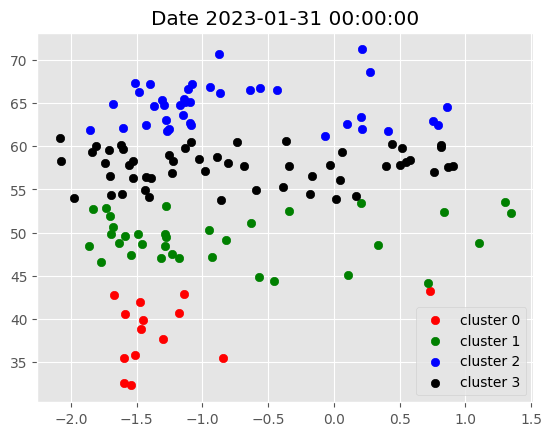

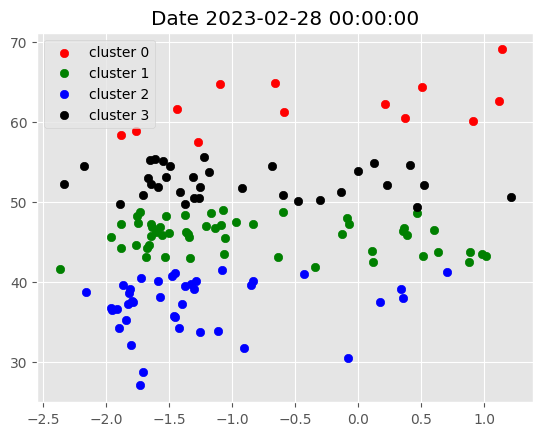

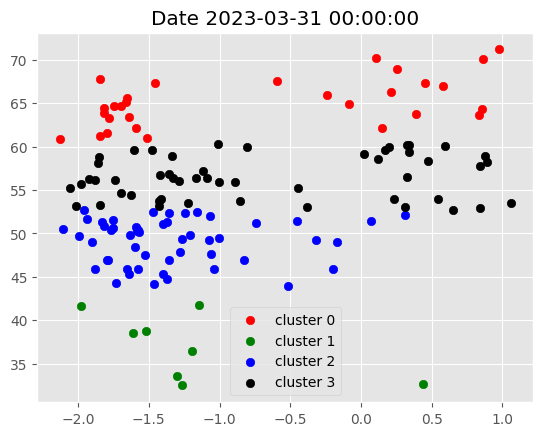

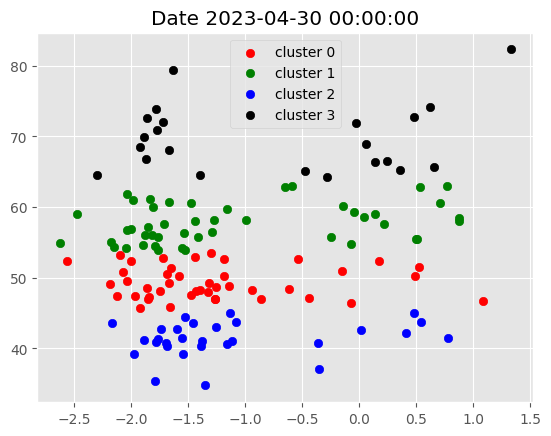

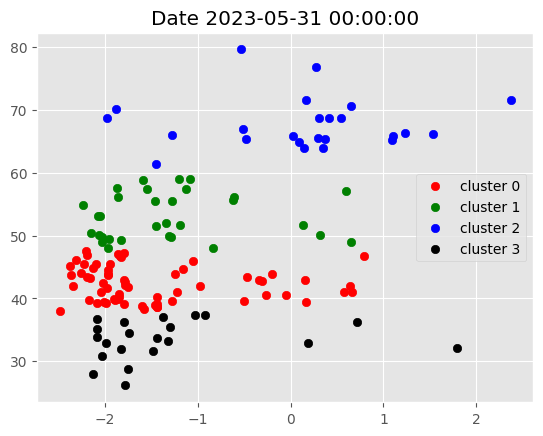

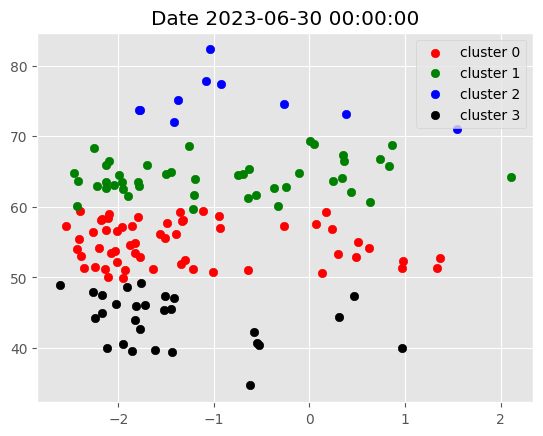

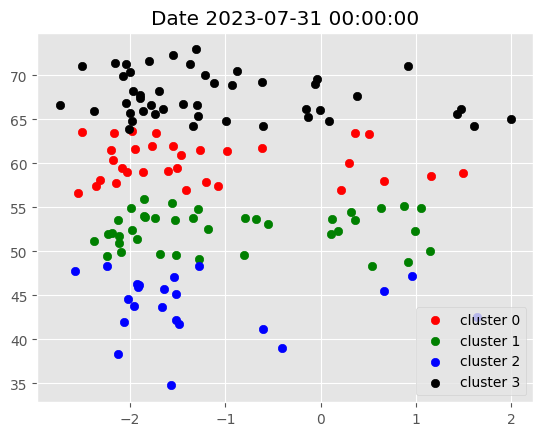

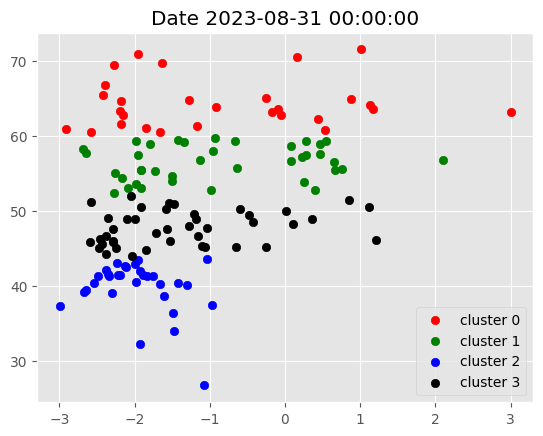

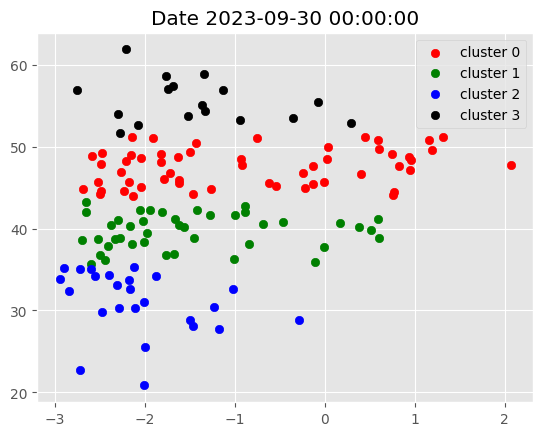

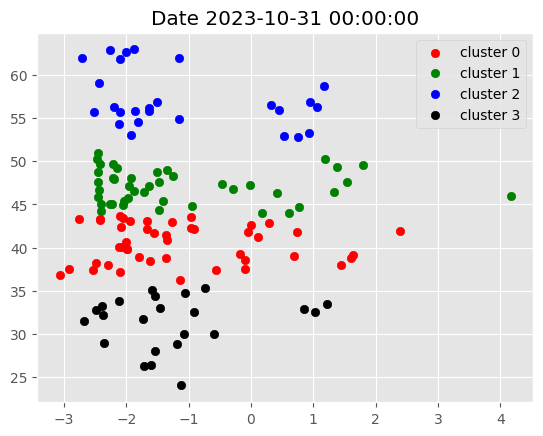

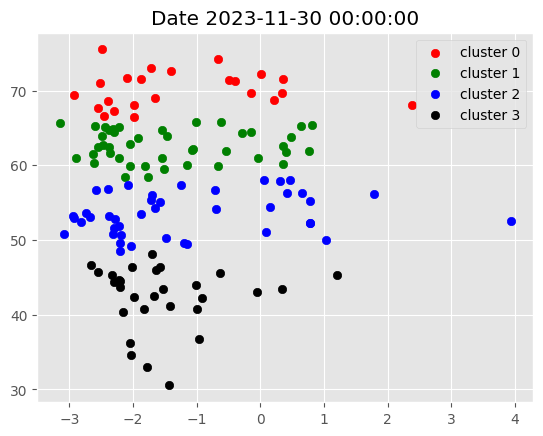

In [35]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f"Date {i}")
    plot_clusters(g)

In [36]:
# Apply pre-defined centroids
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))
initial_centroids[:, 6] = target_rsi_values

In [37]:
data = data.drop('cluster', axis=1)
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                          init=initial_centroids,
                          random_state=0).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

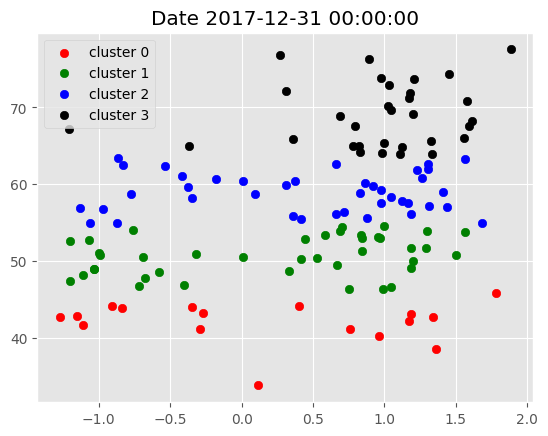

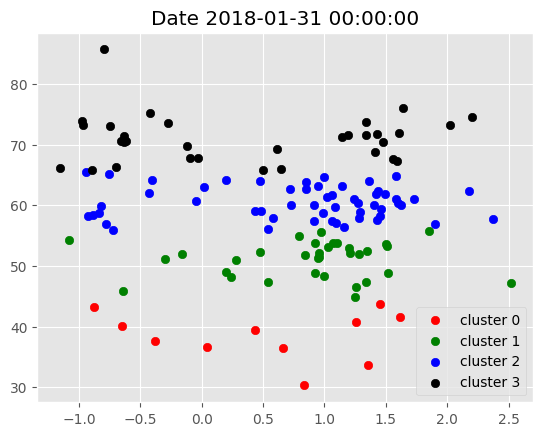

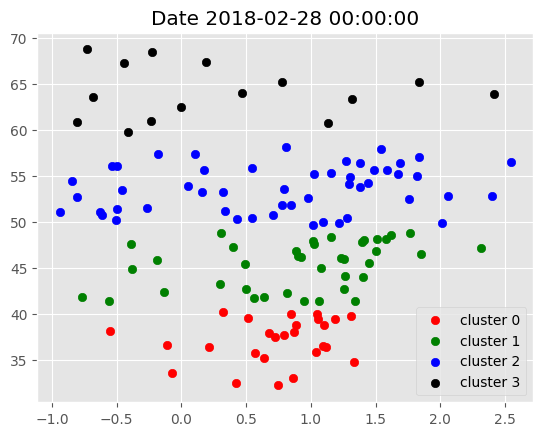

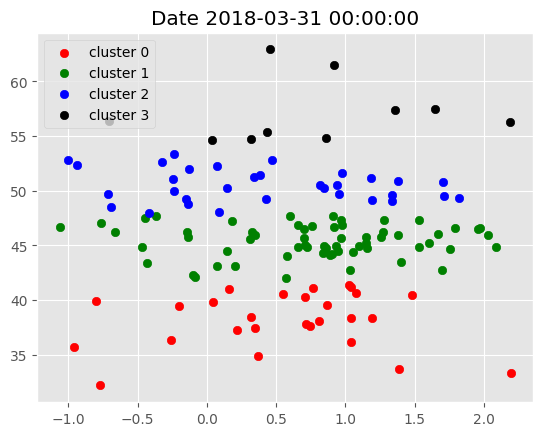

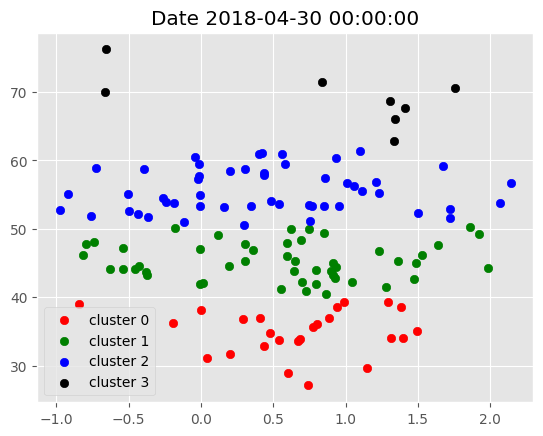

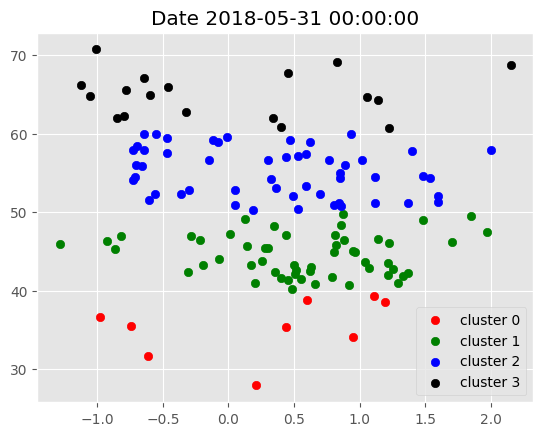

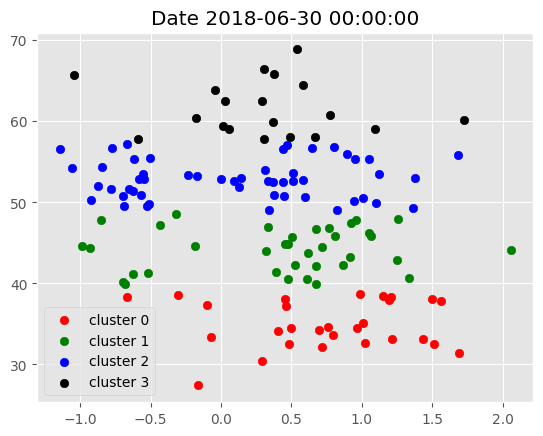

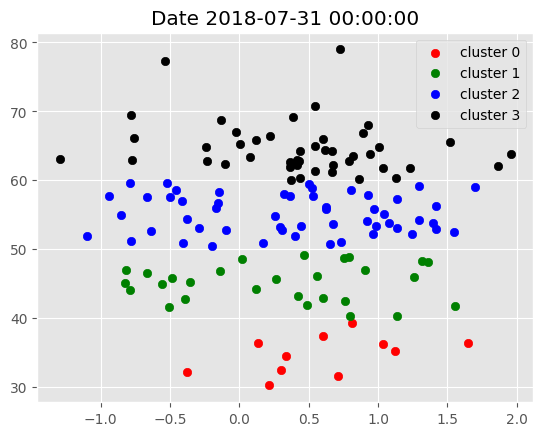

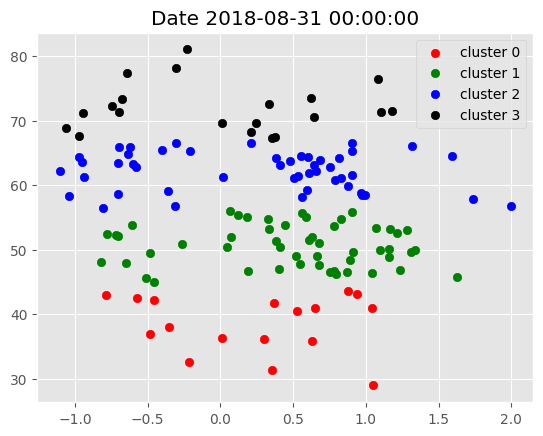

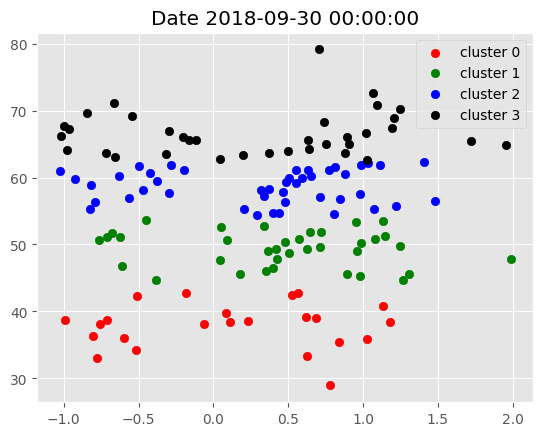

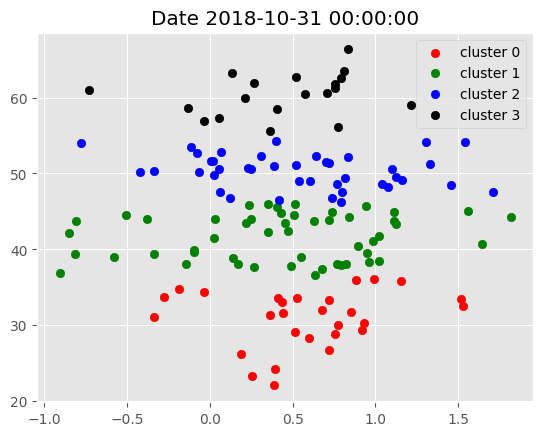

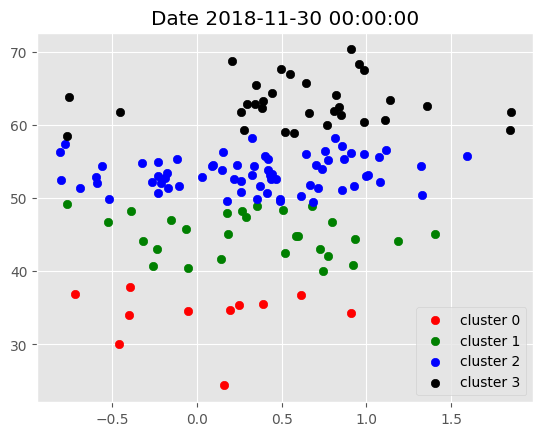

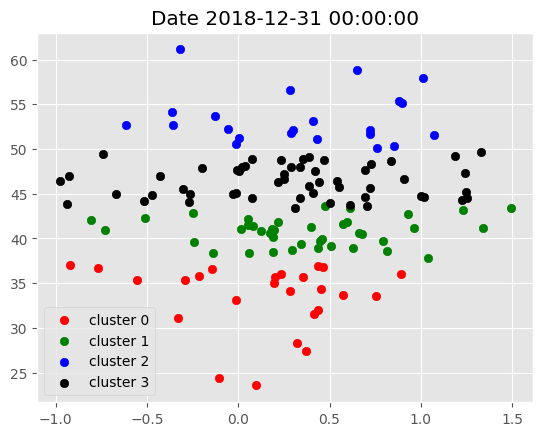

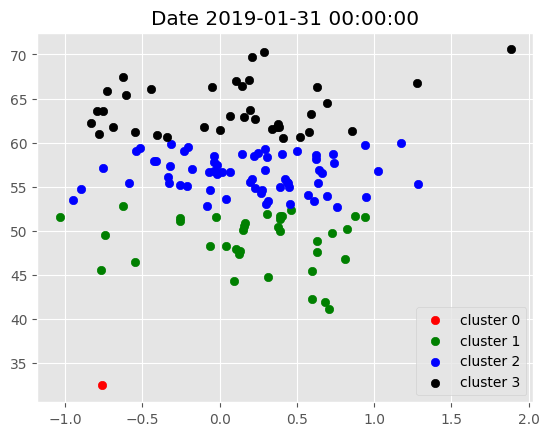

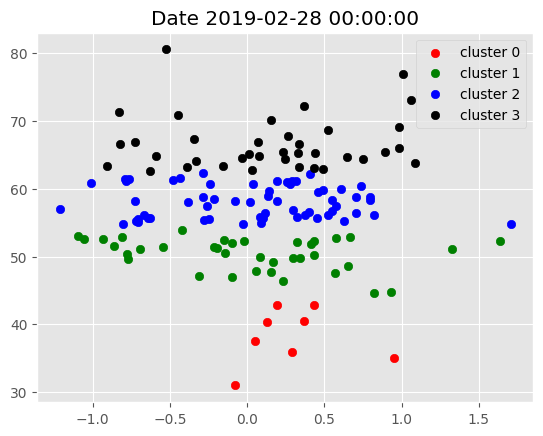

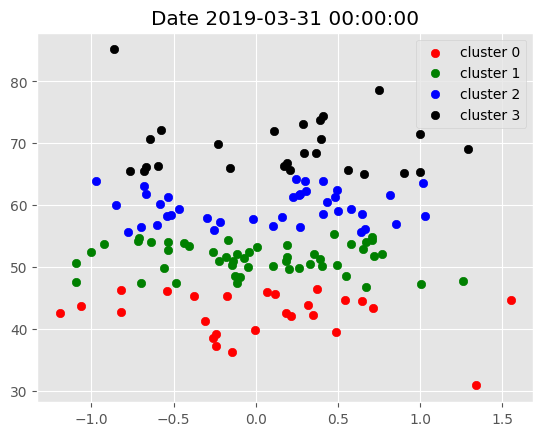

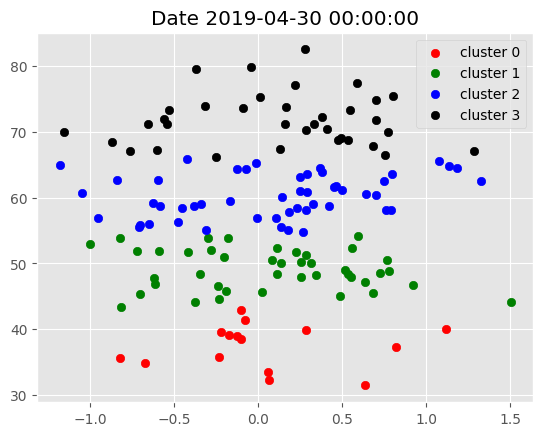

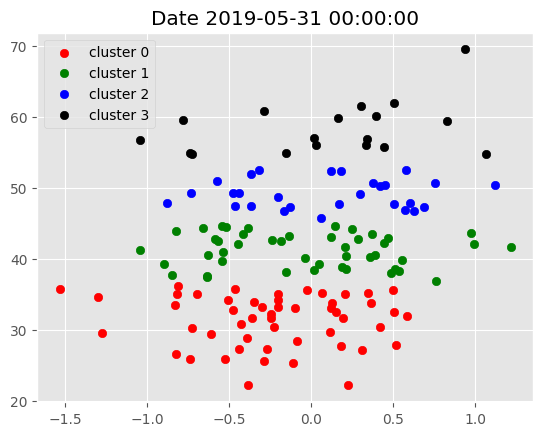

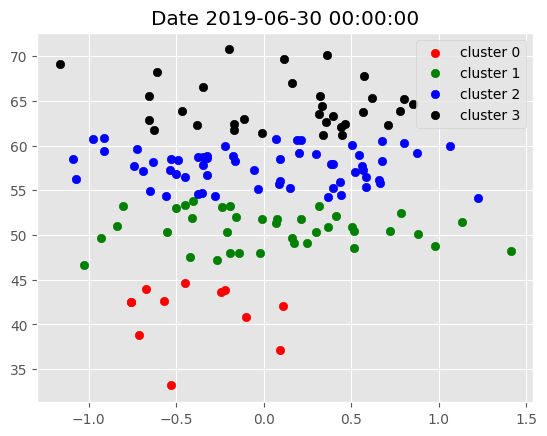

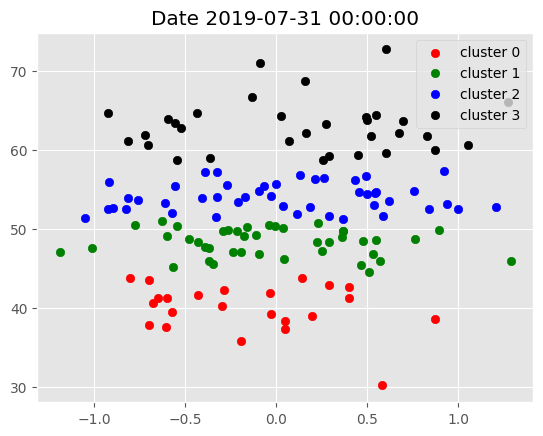

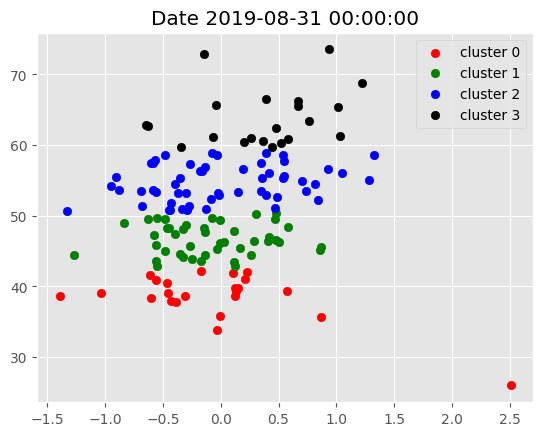

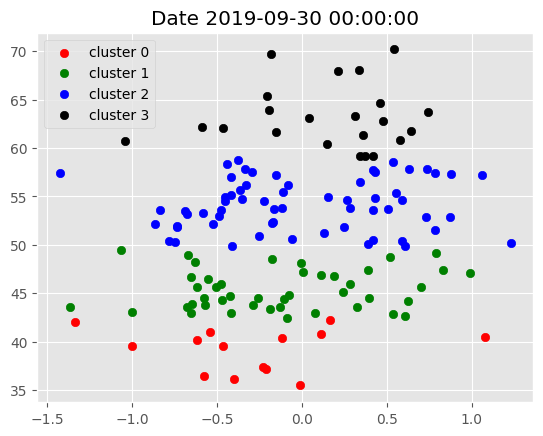

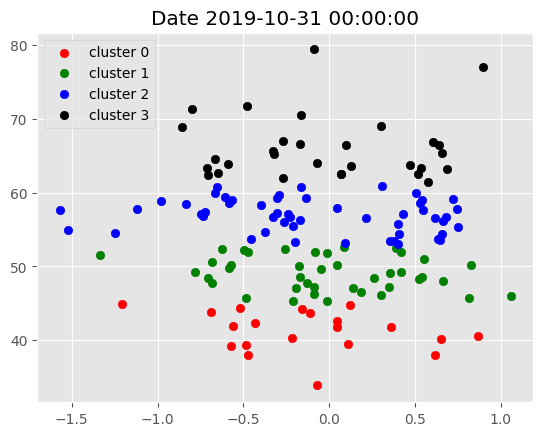

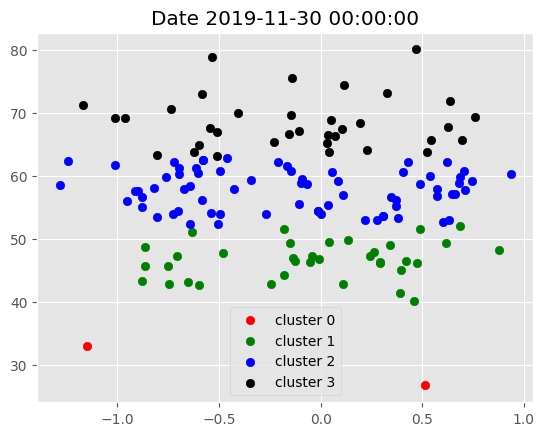

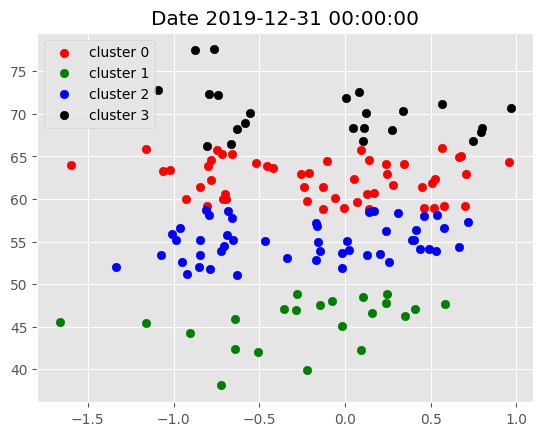

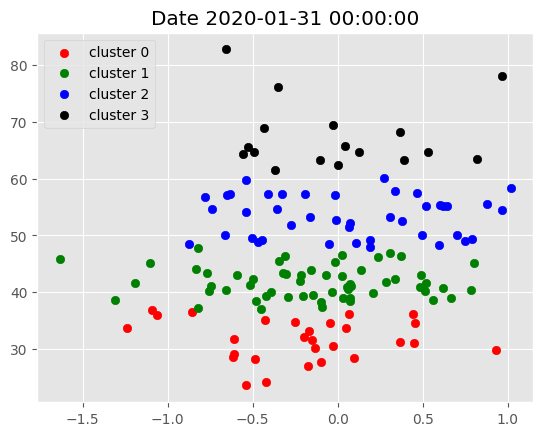

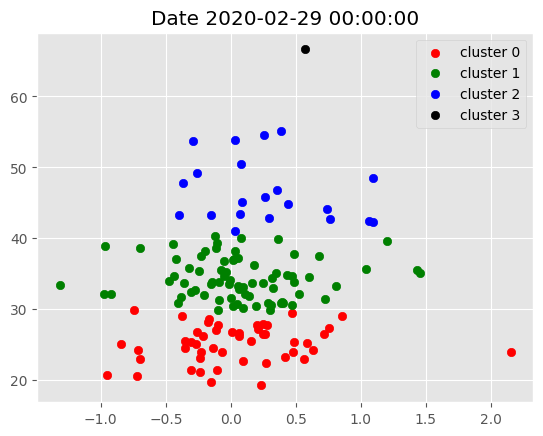

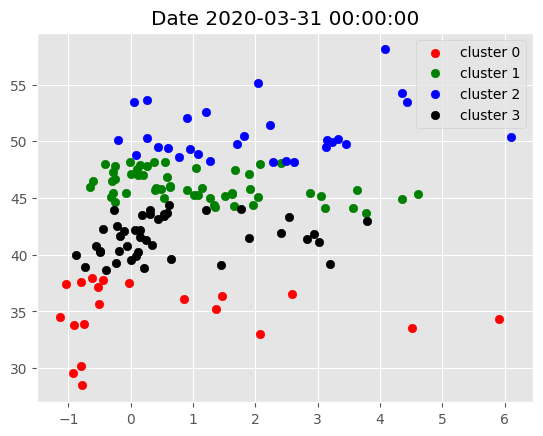

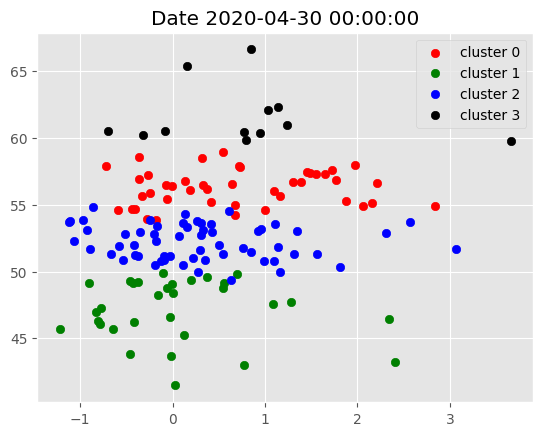

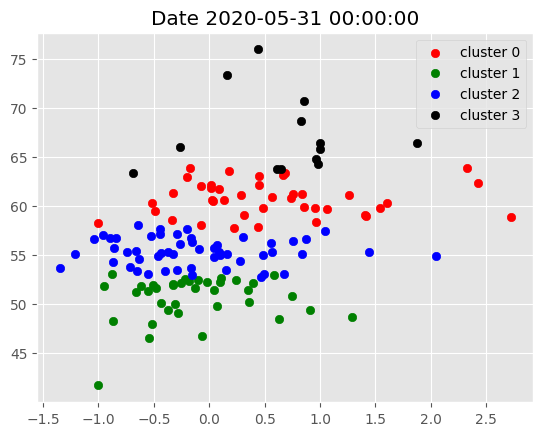

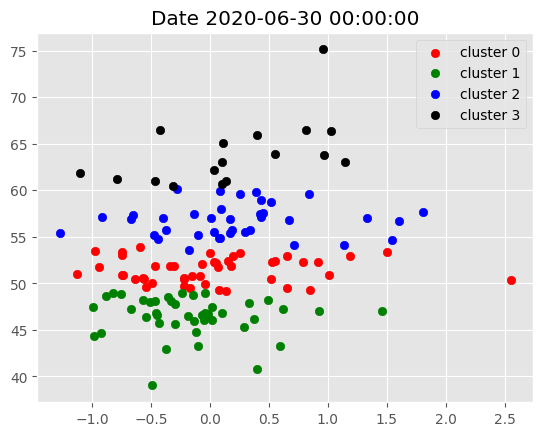

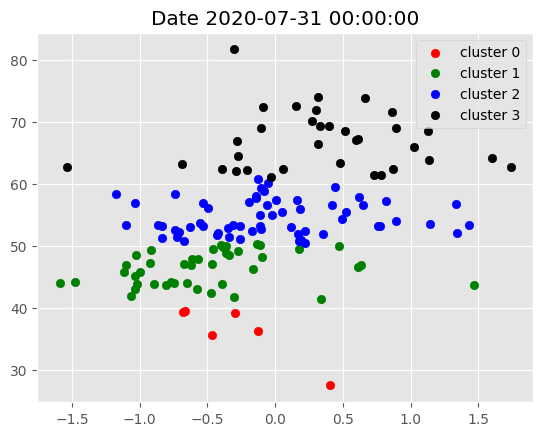

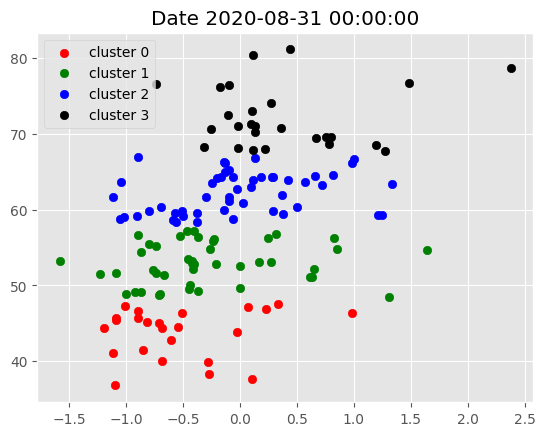

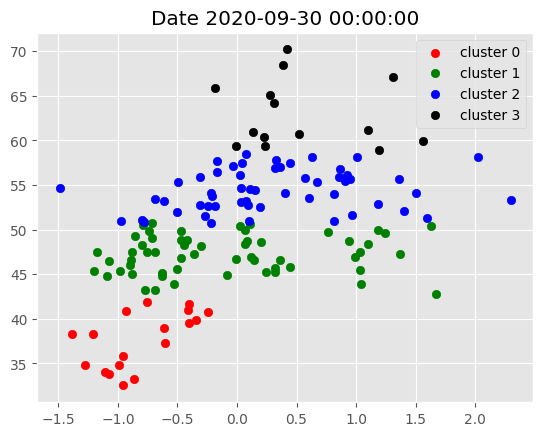

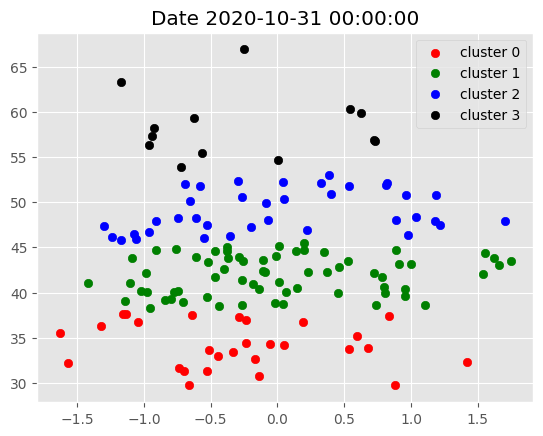

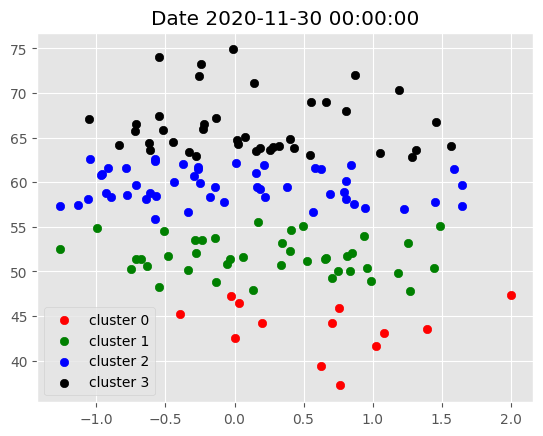

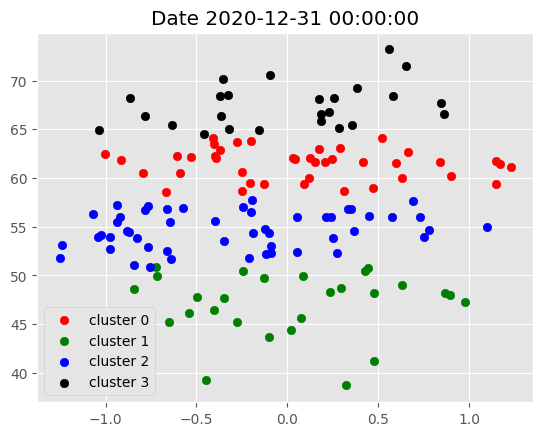

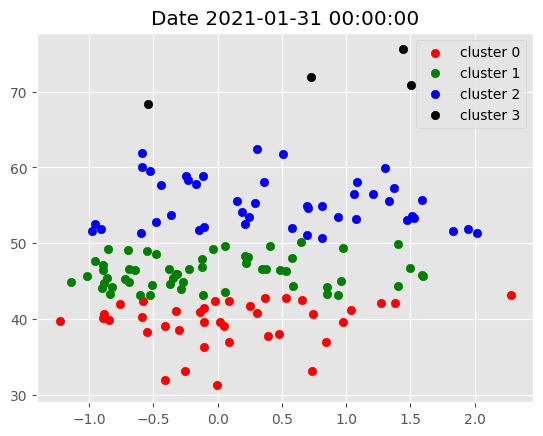

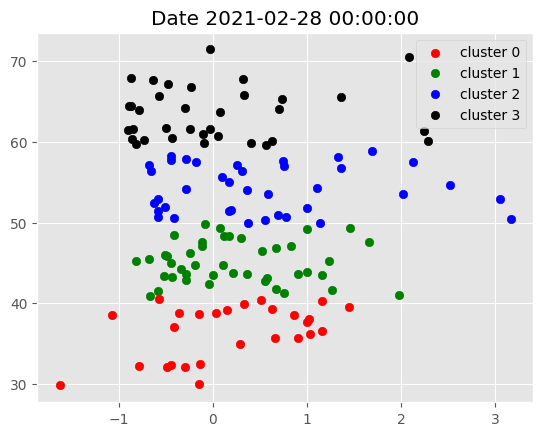

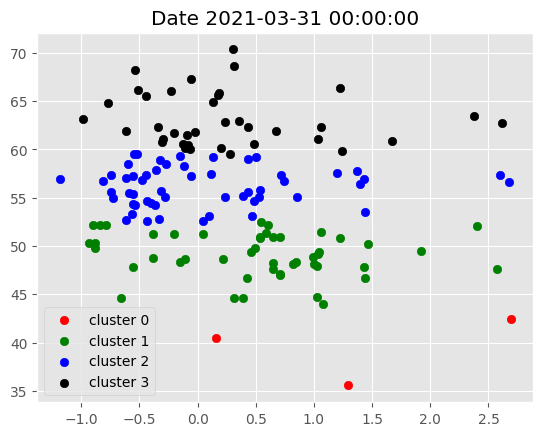

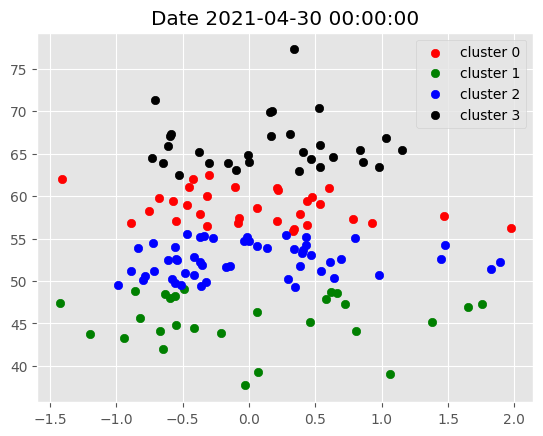

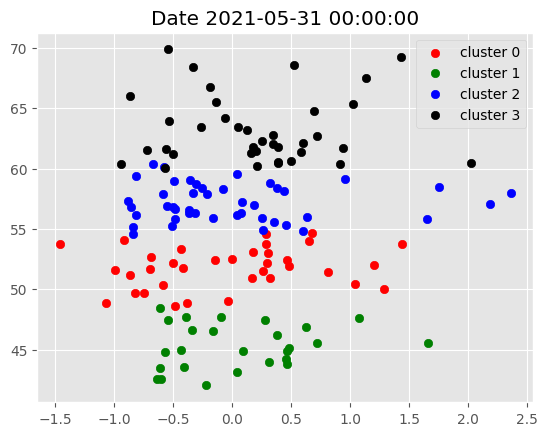

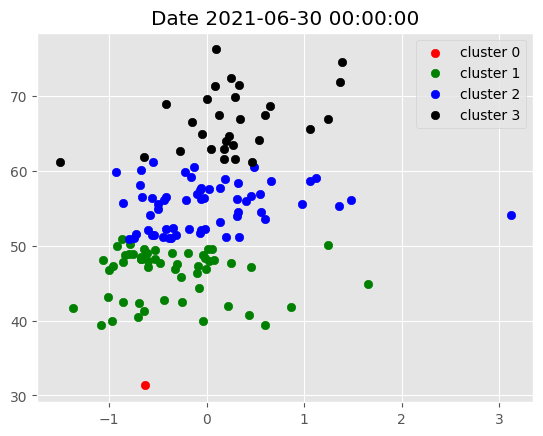

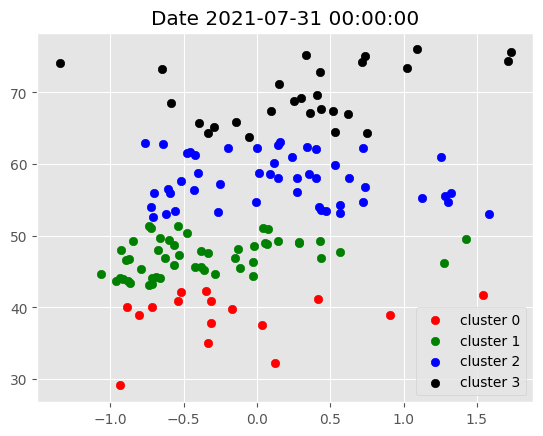

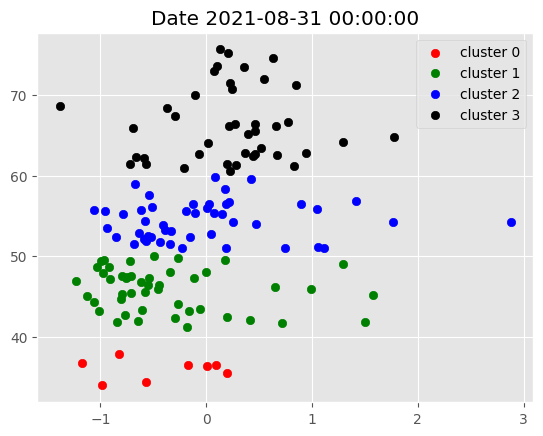

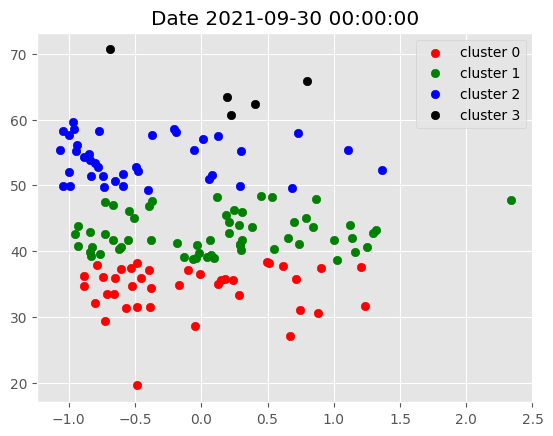

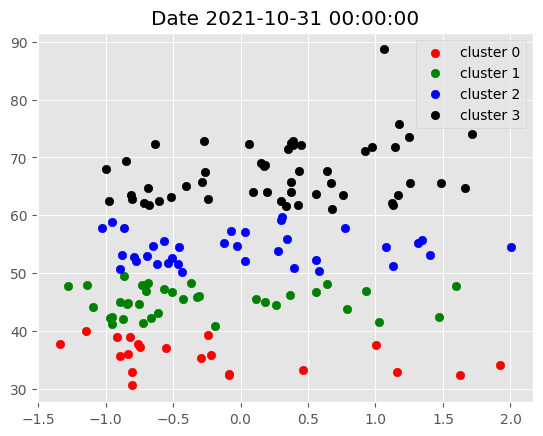

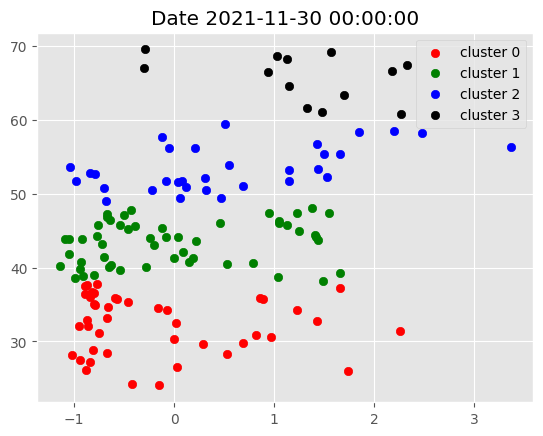

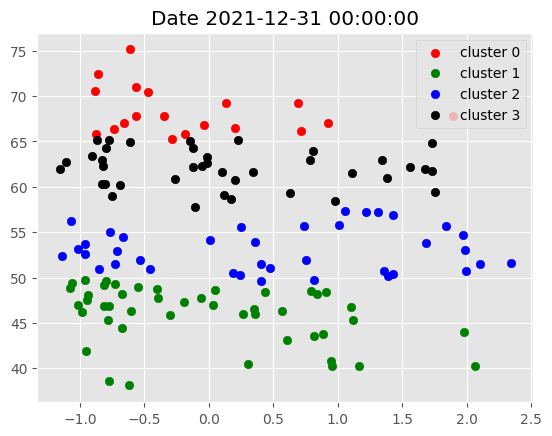

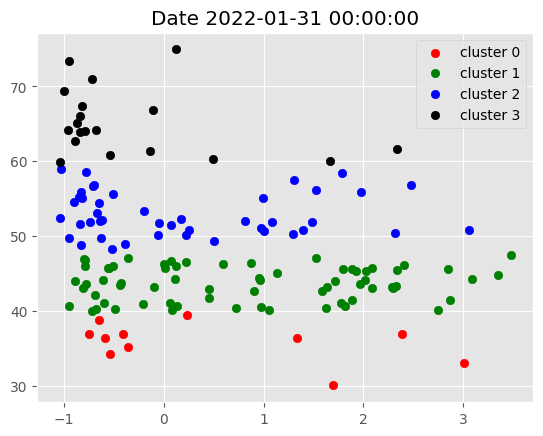

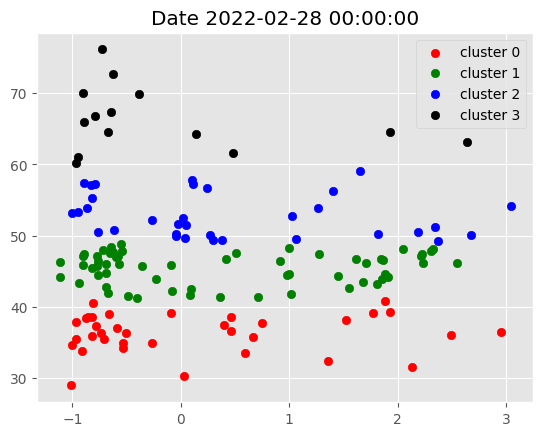

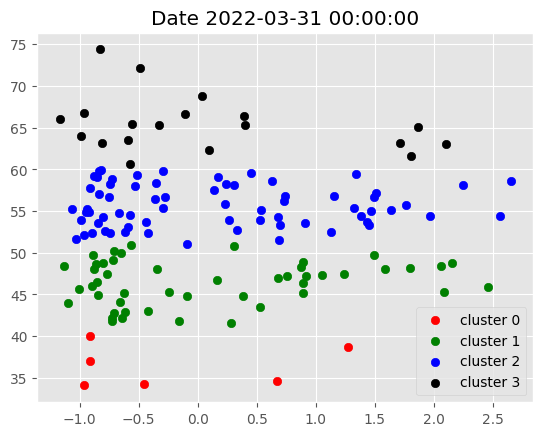

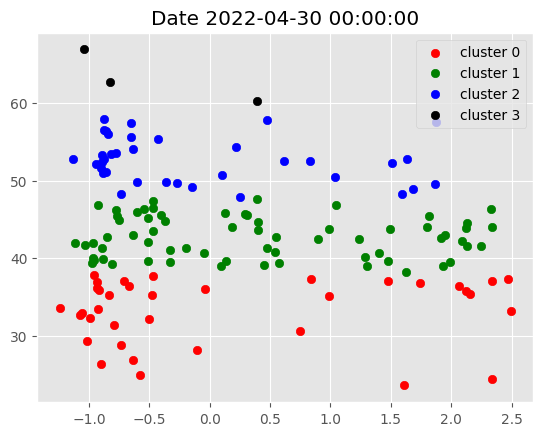

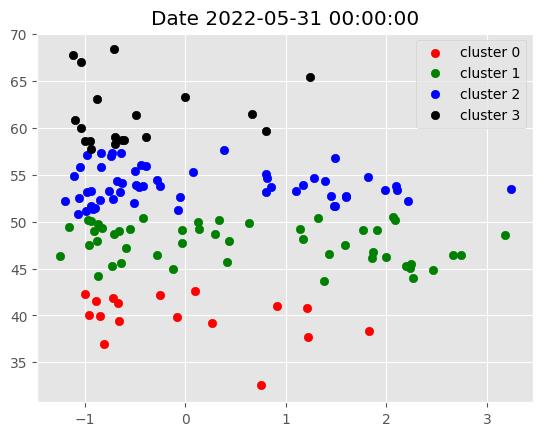

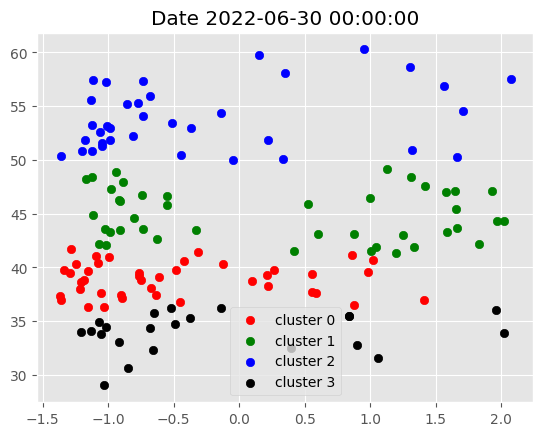

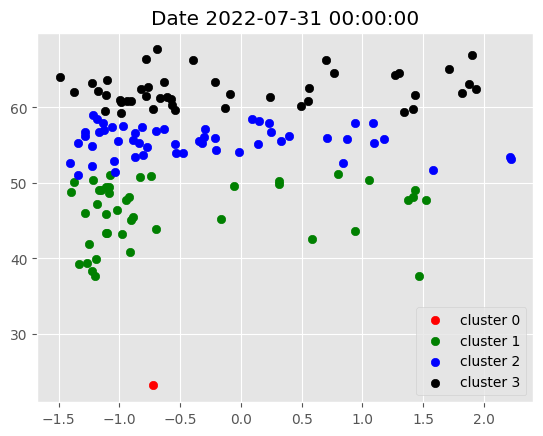

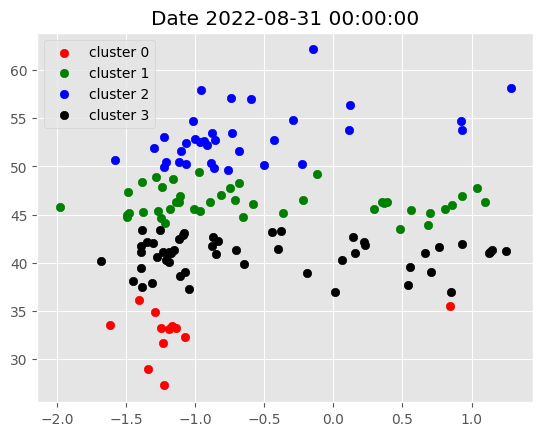

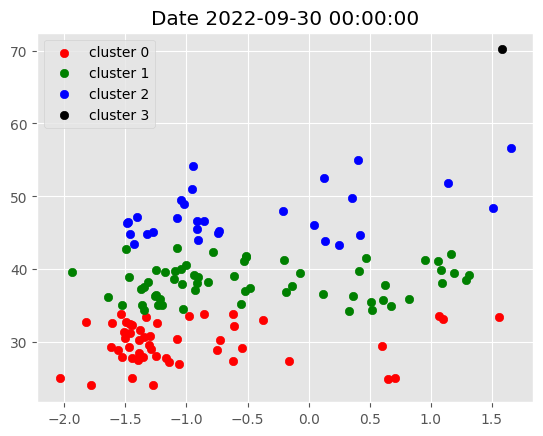

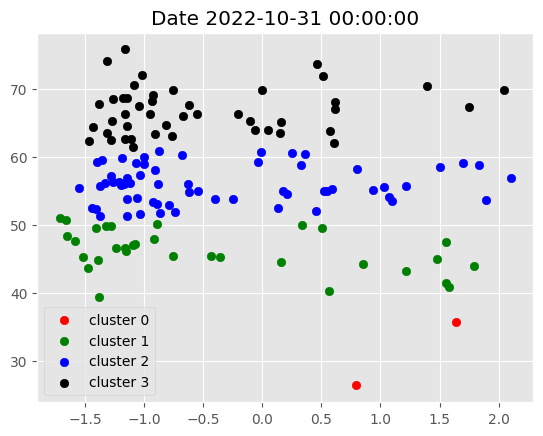

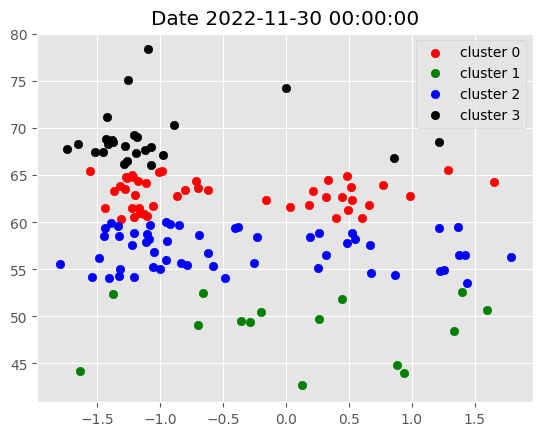

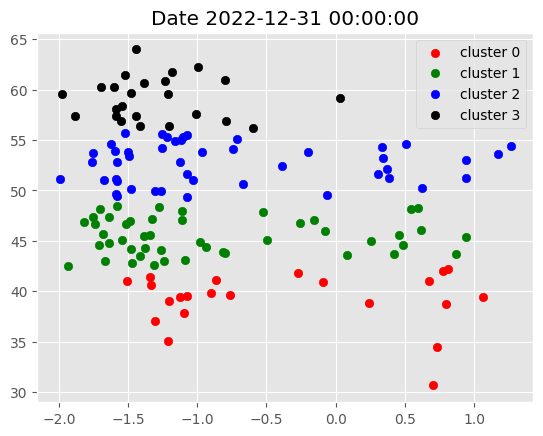

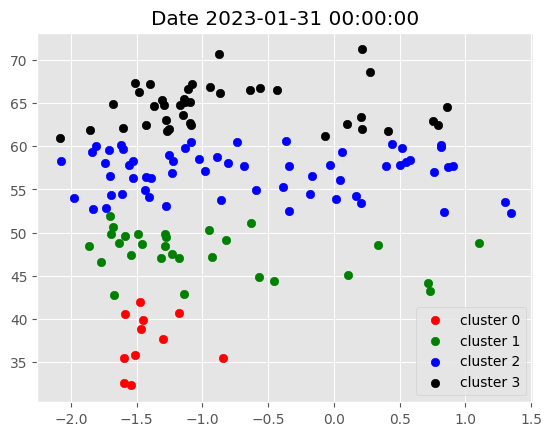

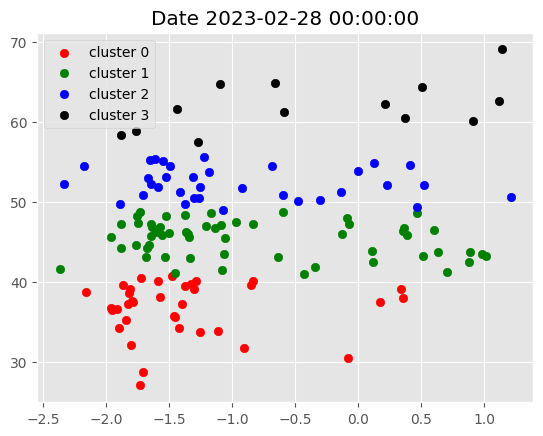

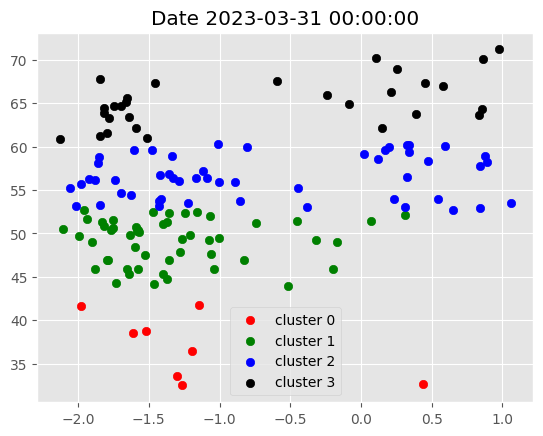

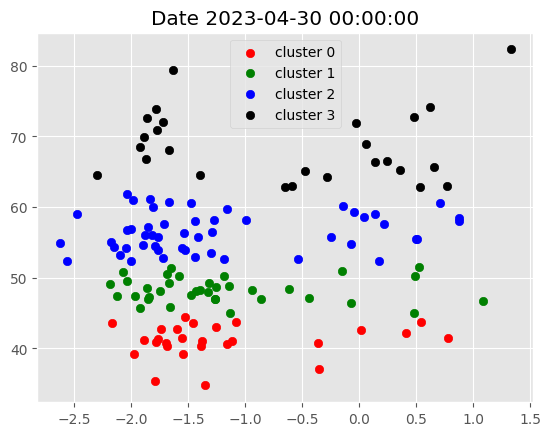

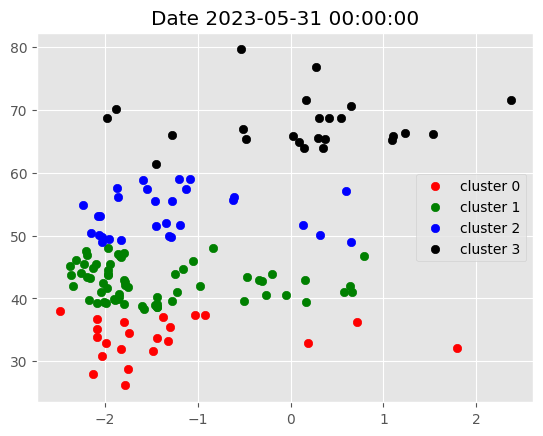

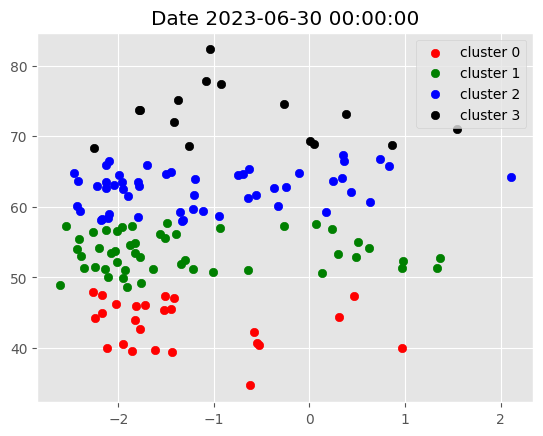

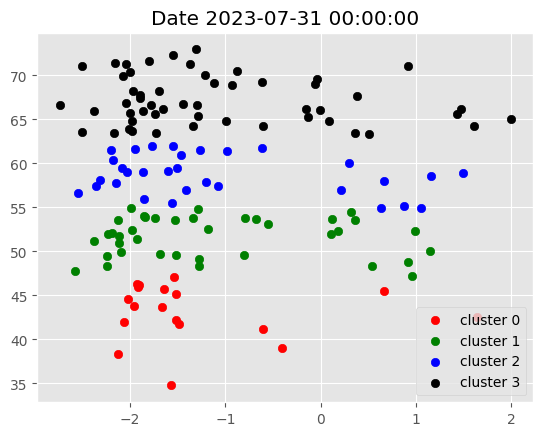

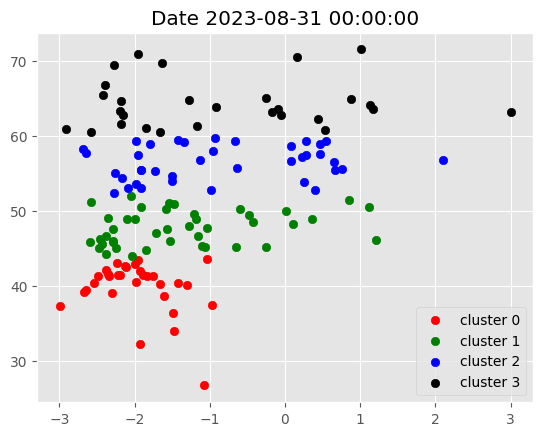

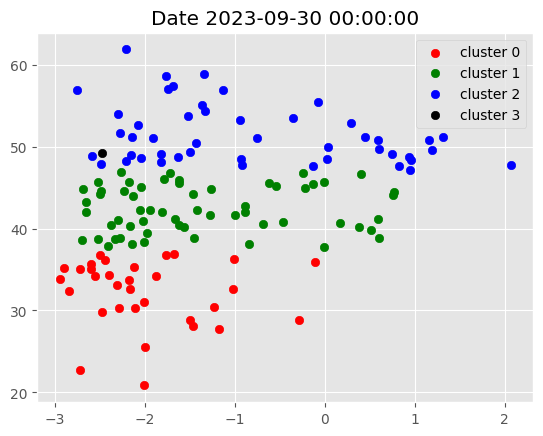

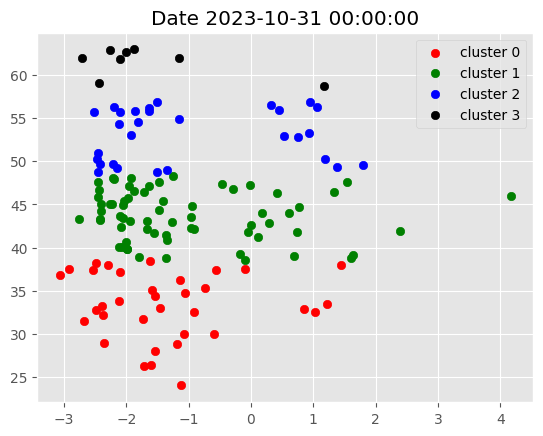

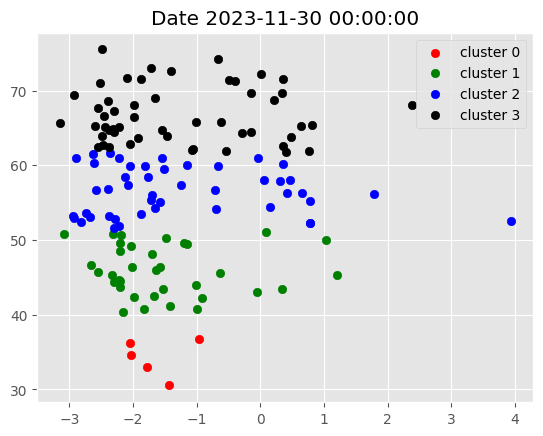

In [38]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f"Date {i}")
    plot_clusters(g)

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [40]:
filtered_data = data[data['cluster']==3].copy()

In [41]:
filtered_data = filtered_data.reset_index(level=1)

In [43]:
filtered_data.index = filtered_data.index + pd.DateOffset(1)

In [47]:
filtered_data = filtered_data.reset_index().set_index(['date', 'ticker'])

In [48]:
dates = filtered_data.index.get_level_values('date').unique().tolist()

# Dictionary of first day of month as key and list of stocks to invest as values
fixed_dates = {}

for date in dates:
    fixed_dates[date.strftime('%Y-%m-%d')] = filtered_data.xs(date, level=0).index.tolist()

In [63]:
fixed_dates

{'2018-01-01': ['ACN',
  'BA',
  'BAC',
  'CAT',
  'CSCO',
  'CVX',
  'DAL',
  'DE',
  'DG',
  'EOG',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'KR',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'PEP',
  'PXD',
  'RTX',
  'STZ',
  'T',
  'TXN',
  'UAL',
  'UNP',
  'VLO',
  'VZ',
  'WMT',
  'WYNN'],
 '2018-02-01': ['ABT',
  'ADBE',
  'AMZN',
  'BA',
  'BAC',
  'BRK-B',
  'CHTR',
  'CRM',
  'CTSH',
  'DG',
  'EA',
  'GD',
  'GOOG',
  'GOOGL',
  'JPM',
  'KR',
  'LMT',
  'LOW',
  'MA',
  'MAR',
  'MSFT',
  'NFLX',
  'NKE',
  'NVDA',
  'NXPI',
  'PNC',
  'PYPL',
  'RTX',
  'TMO',
  'V',
  'WFC',
  'WMT'],
 '2018-03-01': ['AAPL',
  'ADBE',
  'AMZN',
  'BA',
  'BKNG',
  'CRM',
  'CSCO',
  'CTSH',
  'INTC',
  'MA',
  'MU',
  'NFLX',
  'NXPI',
  'PANW',
  'TJX'],
 '2018-04-01': ['AMT',
  'BKNG',
  'CL',
  'COP',
  'INTC',
  'NEE',
  'PANW',
  'STZ',
  'TJX',
  'WYNN'],
 '2018-05-01': ['CMG', 'COP', 'EOG', 'HAL', 'OXY', 'PXD', 'ULTA', 'VLO'],
 '2018-06-01': ['ADBE',
  'AMD',
  'AMZN',
  'BIIB',
  'CMG',
  

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the Sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply single stock weight bounds constraint for diversification (minimum half of equal weight and maximum 10% of portfolio).

In [50]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns

In [72]:
def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices, frequency=252)
    
    cov = risk_models.sample_cov(prices=prices, frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns, cov_matrix=cov, 
                           weight_bounds=(lower_bound, 0.1), solver='SCS', verbose=False, solver_options=None)
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

* Download Fresh Daily Prices Data only for short listed stocks.

In [54]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                    start=data.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12),
                    end=data.index.get_level_values('date').unique()[-1])

[*********************100%***********************]  155 of 155 completed


* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [112]:
returns_dataframe = np.log(new_df['Adj Close']).diff()
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd()).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices = optimization_df, lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
            
        except:
            print(f'Max Sharpe Optimization Failed for {start_date}, continuing with equal weights!')
            
        if success == False:
            weights = pd.DataFrame([1/(len(optimization_df.columns)) for i in range(len(optimization_df.columns))],
                                    index=optimization_df.columns.to_list(),
                                    columns=pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
        .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
              left_index=True, right_index=True)\
        .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Returns')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis = 0)
        
    except Exception as e:
        print(e)
        
portfolio_df = portfolio_df.drop_duplicates()

Max Sharpe Optimization Failed for 2018-05-01, continuing with equal weights!
Max Sharpe Optimization Failed for 2020-03-01, continuing with equal weights!
Max Sharpe Optimization Failed for 2020-04-01, continuing with equal weights!
Max Sharpe Optimization Failed for 2021-02-01, continuing with equal weights!
Max Sharpe Optimization Failed for 2021-10-01, continuing with equal weights!
Max Sharpe Optimization Failed for 2022-05-01, continuing with equal weights!
Max Sharpe Optimization Failed for 2022-07-01, continuing with equal weights!
Max Sharpe Optimization Failed for 2022-09-01, continuing with equal weights!
Max Sharpe Optimization Failed for 2022-10-01, continuing with equal weights!
Max Sharpe Optimization Failed for 2023-10-01, continuing with equal weights!
Max Sharpe Optimization Failed for 2023-11-01, continuing with equal weights!
'return'


In [113]:
portfolio_df

Strategy Returns
date                        
2018-01-02         -0.000918
2018-01-03          0.003473
2018-01-04          0.001659
2018-01-05          0.005059
2018-01-08          0.002029
...                      ...
2023-11-22          0.009437
2023-11-24          0.002481
2023-11-27         -0.005560
2023-11-28          0.002558
2023-11-29         -0.016890

[1488 rows x 1 columns]

<Axes: xlabel='date'>

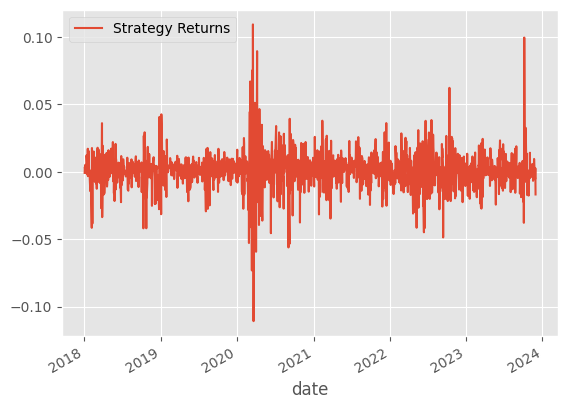

In [114]:
portfolio_df.plot()

In [69]:
optimization_df = new_df['2017-01-01':'2017-12-31']['Adj Close'][fixed_dates['2018-01-01']]

In [78]:
weights = optimize_weights(prices = optimization_df, lower_bound=round(1/(len(optimization_df.columns)*2),3))

In [77]:
round(1/(len(optimization_df.columns)*2),3)

0.016

In [80]:
pd.DataFrame(weights, index=pd.Series(0))

ACN   BA    BAC    CAT   CSCO    CVX    DAL       DE     DG    EOG  ...  \
0  0.016  0.1  0.016  0.037  0.016  0.016  0.016  0.01625  0.016  0.016  ...   

     RTX  STZ      T    TXN    UAL    UNP    VLO     VZ  WMT  WYNN  
0  0.016  0.1  0.016  0.016  0.016  0.016  0.016  0.016  0.1   0.1  

[1 rows x 31 columns]

In [81]:
temp_df = returns_dataframe['2018-01-01':'2018-01-31']

In [93]:
temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
    .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
          left_index=True, right_index=True)\
    .reset_index().set_index(['Date', 'index']).unstack().stack()

In [86]:
weights = pd.DataFrame(weights, index=pd.Series(0))

In [94]:
temp_df.index.names = ['date', 'ticker']

In [99]:
temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Returns')

Strategy Returns
date                        
2018-01-02         -0.000918
2018-01-03          0.003473
2018-01-04          0.001659
2018-01-05          0.005059
2018-01-08          0.002029
2018-01-09          0.005132
2018-01-10         -0.000863
2018-01-11          0.012085
2018-01-12          0.009898
2018-01-16         -0.002430
2018-01-17          0.017015
2018-01-18         -0.003319
2018-01-19          0.009217
2018-01-22          0.015202
2018-01-23          0.000887
2018-01-24         -0.002671
2018-01-25          0.001330
2018-01-26         -0.003397
2018-01-29         -0.014444
2018-01-30         -0.003660
2018-01-31         -0.000040

In [96]:
temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']

In [97]:
temp_df

return  weight  weighted_return
date       ticker                                   
2018-01-02 ACN     0.004887   0.016         0.000078
           BA      0.006523   0.100         0.000652
           BAC     0.012791   0.016         0.000205
           CAT    -0.003432   0.037        -0.000127
           CSCO    0.014516   0.016         0.000232
...                     ...     ...              ...
2018-01-31 UNP    -0.013837   0.016        -0.000221
           VLO     0.017131   0.016         0.000274
           VZ      0.003149   0.016         0.000050
           WMT    -0.010544   0.100        -0.001054
           WYNN   -0.034427   0.100        -0.003443

[651 rows x 3 columns]

In [111]:
pd.DataFrame([1/(len(optimization_df.columns)) for i in range(len(optimization_df.columns))],
                index=optimization_df.columns.to_list(),
                columns=pd.Series(0)).T

AAPL       ABT       ACN      ADBE       AMD       AMT       AXP  \
0  0.019608  0.019608  0.019608  0.019608  0.019608  0.019608  0.019608   

         BA       BAC       BLK  ...      SCHW       SHW         T       TGT  \
0  0.019608  0.019608  0.019608  ...  0.019608  0.019608  0.019608  0.019608   

       TMUS      UBER       USB         V        VZ       WFC  
0  0.019608  0.019608  0.019608  0.019608  0.019608  0.019608  

[1 rows x 51 columns]